# CEIA – Análisis de Series de Tiempo I | TP3: Trabajo Final

Notebook del TP3 de la materia **Análisis de Series de Tiempo I** de la Carrera de Especialización en Inteligencia Artificial (CEIA – UBA).

---

**Alumno**

- **Emiliano Iparraguirre** (<emiliano.iparraguirre22@gmail.com>)  
---
**Objetivo del trabajo**

El presente trabajo tiene como objetivo aplicar técnicas de **análisis de series de tiempo** para predecir la **demanda semanal del producto “Salamin picado fino – 1ra marca (Código 1)”** de una empresa nacional del sector alimenticio, especializada en la elaboración de fiambres y embutidos.  
El horizonte de proyección considerado es de **52 semanas (un año)**, utilizando datos históricos de ventas semanales comprendidos entre los años **2016 y 2020**.

A partir de los datos, se busca **evaluar y comparar distintos enfoques de modelado temporal** —incluyendo modelos **SARIMA**, **Holt-Winters (ETS)** y **SARIMAX**— con el fin de determinar cuál ofrece **mayor precisión y estabilidad predictiva**, contribuyendo a la **planificación de producción y abastecimiento** de la empresa.

---

**Pregunta de investigación**

> ¿Cuál será la demanda semanal del producto Salamin picado fino (Código 1) durante las próximas 52 semanas y qué modelo de series temporales (SARIMA, SARIMAX o Holt-Winters) permite obtener el pronóstico más preciso para la empresa procesadora de alimentos?

---

**Alcance**

El análisis considera exclusivamente la serie histórica de **pedidos semanales del producto Código 1**, expresados en **kilogramos**, obtenidos a partir del registro de ventas de la empresa.  
Se modela la serie como una **serie temporal univariada**, sobre la cual se aplican técnicas de **descomposición**, **verificación de estacionariedad**, y **ajuste de distintos modelos de pronóstico**.

Posteriormente, se proyectan las **52 semanas siguientes al último dato histórico disponible**, y se comparan los resultados de los modelos mediante métricas de desempeño como:

- **RMSE** (Root Mean Squared Error)  
- **MAE** (Mean Absolute Error)  
- **MAPE** (Mean Absolute Percentage Error)  
- **R²** (coeficiente de determinación)  
- **% de semanas con error < 30%**

---
**Datos y utilidades**
- 

In [1]:
# ==== 0. Setup ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

# opcional (auto-ARIMA)
# pip install pmdarima
from pmdarima import auto_arima

**Descripción de los datos**

La base de datos utilizada proviene de los registros históricos de **pedidos semanales** de productos elaborados por la empresa, correspondientes al período comprendido entre **enero de 2016 y julio de 2020**.  
Cada observación representa la cantidad total de kilogramos pedidos por semana para un producto determinado.

El archivo original se encuentran en la carpeta `data/Pedidosporcod.xlsx` y contienen los siguientes productos:

| Código | Producto | Tipo de relación | Archivo fuente |
|:------:|:----------|:-----------------|:----------------|
| **COD1** | Salamin picado fino – *1ra marca* | Producto base (variable endógena) | `Pedidosporcod.xlsx` |
| **COD2** | Salamin picado grueso – *1ra marca* | Producto **complementario** | `Pedidosporcod.xlsx` |
| **COD24** | Salamin picado fino – *2da marca* | Producto **sustituto** del COD1 | `Pedidosporcod.xlsx` |
| **COD25** | Salamin picado grueso – *2da marca* | Producto **sustituto** del COD2 | `Pedidosporcod.xlsx` |

Además, se dispone de un archivo adicional denominado **`Pedidos_real.xlsx`**, que contiene la **serie de test** para el producto **COD1 (Salamin picado fino – 1ra marca)**.  
Este conjunto de datos fue utilizado para **evaluar la capacidad predictiva de los modelos** mediante métricas de desempeño como RMSE, MAPE, MAE, R² y precisión en cantidad de semanas con error menor al 30%.

Cada dataset mantiene la misma estructura de columnas:

| Columna | Descripción |
|----------|-------------|
| `año` | Año calendario correspondiente a la observación. |
| `semana` | Semana del año (de 1 a 52). |
| `COD#` | Cantidad pedida (en kilogramos) del producto correspondiente al código. |

Durante el proceso de limpieza y exploración:

- Las series fueron **convertidas a frecuencia semanal explícita (`W-MON`)**.  
- Se **verificó la ausencia de valores nulos** tras la reindexación y se aplicó *forward-fill* cuando fue necesario.  
- Las variables exógenas (`COD2`, `COD24`, `COD25`) se **estandarizaron (z-score)** para garantizar comparabilidad de magnitudes en el modelo SARIMAX.  
- La variable `COD1` se utilizó como serie principal de análisis y pronóstico, representando la demanda semanal del producto **Salamin picado fino – 1ra marca**.


---

**Estructura y frecuencia temporal**

- **Frecuencia:** semanal (`frequency = 52`)  
- **Número total de observaciones:** 235 semanas  
- **Rango temporal:** desde la **semana 1 del año 2016** hasta la **semana 27 del año 2020**  
- **Unidad de medida:** kilogramos (Kg)  
- **Porcentaje de valores faltantes:** 0% (no se registran NAs en la serie)  
- **Tipo de serie:** univariada cuantitativa continua  

La serie se convierte a un objeto temporal (`DatetimeIndex` en Python) con frecuencia semanal y se verifica su correcta ordenación y completitud.  
Posteriormente, se realiza un gráfico exploratorio inicial que permite observar:

- Tendencia creciente hasta finales de 2017.  
- Caída sostenida desde 2018.  
- Estacionalidad marcada, con picos recurrentes en determinadas semanas del año.

---

**Contexto empresarial**

El producto analizado pertenece a la **línea de embutidos curados de la empresa**, distribuido a nivel nacional a través de canales mayoristas y minoristas.  
La **planificación de la demanda** resulta crítica para coordinar los procesos de **maduración, producción y distribución**, donde el tiempo de ciclo puede superar las 4 semanas.  
Contar con un modelo de previsión confiable permite optimizar inventarios, minimizar rupturas de stock y planificar la capacidad productiva en función de la demanda esperada.

## 1. Análisis exploratorio de la serie (EDA)

El objetivo de esta sección es **comprender el comportamiento histórico de la serie temporal** correspondiente a los pedidos semanales del producto *Salamin picado fino – 1ra marca (Código 1)*.  
Antes de aplicar modelos de predicción, se busca **analizar su estructura interna**, verificando la presencia de **tendencia, estacionalidad y posibles quiebres**, así como la **estacionariedad** de la serie.

El análisis exploratorio permitirá determinar **qué transformaciones son necesarias** (por ejemplo, diferenciación o remoción de tendencia) y **orientar la elección del modelo** más adecuado para el pronóstico posterior.

En particular, se abordarán los siguientes aspectos:

1. **Visualización general de la serie**: observar la tendencia global y variaciones en la demanda.  
2. **Detección de patrones estacionales**: analizar si existen comportamientos repetitivos anuales o semanales.  
3. **Descomposición de la serie temporal** en sus componentes: tendencia, estacionalidad y residuo.  
4. **Análisis de autocorrelación (ACF/PACF)** para explorar dependencias entre observaciones pasadas.  
5. **Verificación de estacionariedad** mediante pruebas estadísticas (ADF y KPSS).  
6. **Remoción de tendencia determinística** y evaluación de la serie transformada.
7. **Primera diferencia (no estacional)** y evaluación de la serie diferenciada.

Este proceso permitirá **diagnosticar la dinámica temporal** de la demanda y preparar la serie para su posterior modelado con técnicas como **SARIMA**, **SARIMAX** y **Holt-Winters**.

**Consideraciones importantes**

Primero vamos a preparar la serie de la valiable a pronosticar por separado, luego vamos a revisar las otras variables que serán usadas como exógenas en los modelos que admitan agregarlas.

---

### 1.1. Visualización general de la serie

Antes de aplicar cualquier transformación o modelado, se realiza una **inspección visual de la serie temporal** correspondiente a los pedidos semanales del producto *Salamin picado fino – 1ra marca (Código 1)*.  
Este paso permite identificar **patrones de comportamiento globales**, como tendencia, variabilidad y posibles estacionalidades.

El gráfico al final de esta sección muestra la evolución de la demanda semanal (en kilogramos) durante el período 2016–2020:

In [26]:
# ==== 1. Datos ====
# Leer el Excel
df = pd.read_excel("data/Pedidosporcod.xlsx")

# Verificar estructura
print(df.head())

    año  semana    COD1    COD2   COD24   COD25
0  2016       1  9126.5  4815.2  2604.4  1930.4
1  2016       2  7458.4  4309.8  1934.4  1430.8
2  2016       3  8848.0  4950.3  2294.6  1228.4
3  2016       4  7353.6  4242.7  1877.4  1200.6
4  2016       5  8304.0  3581.8  2097.0  1252.6


In [27]:
# Combinar 'año' y 'semana' en una fecha: tomamos el lunes de cada semana ISO
df['fecha'] = pd.to_datetime(df['año'].astype(str) + df['semana'].astype(str) + '1', format='%G%V%u')

# Renombrar la columna de pedidos
df = df.rename(columns={'COD1': 'demanda'})

# Ordenar y fijar índice temporal
df = df.sort_values('fecha').set_index('fecha')

# Asegurar frecuencia semanal explícita
y = df['demanda'].asfreq('W-MON')  # W-MON = semanas que terminan en lunes (alineado con ISO)

# Mostrar primeros valores
print(y.head(10))
print(y.describe())

fecha
2016-01-04    9126.5
2016-01-11    7458.4
2016-01-18    8848.0
2016-01-25    7353.6
2016-02-01    8304.0
2016-02-08    7379.5
2016-02-15    9313.8
2016-02-22    8722.5
2016-02-29    8143.4
2016-03-07    8730.9
Freq: W-MON, Name: demanda, dtype: float64
count      235.000000
mean      7817.434085
std       2114.047386
min       3266.800000
25%       6452.000000
50%       7607.000000
75%       8856.400000
max      15400.400000
Name: demanda, dtype: float64


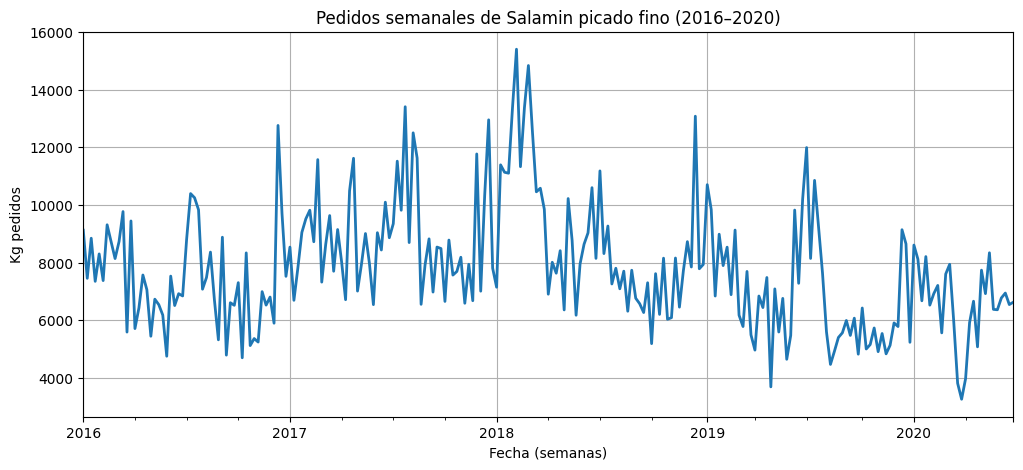

In [28]:
# ==== 2. EDA básico ====
y.plot(figsize=(12,5), title="Pedidos semanales de Salamin picado fino (2016–2020)", lw=2)
plt.ylabel("Kg pedidos")
plt.xlabel("Fecha (semanas)")
plt.grid(True)
plt.show()

#### Conclusiones del gráfico de la serie temporal

Al observar la evolución de los pedidos semanales del producto *Salamin picado fino (Código 1)* entre 2016 y 2020, se identifican **oscilaciones periódicas** en torno a una media que desciende gradualmente a partir de 2018.  
El comportamiento de la serie refleja no solo la **dinámica interna del consumo estacional de embutidos**, sino también **factores macroeconómicos** y coyunturales que afectaron al sector alimenticio en Argentina durante este período.

**Principales hitos y observaciones:**

1. **2016 – Inicio del período:**  
   La demanda comienza en niveles altos, con una ligera volatilidad. Este año coincide con el inicio de la gestión de gobierno de Mauricio Macri y un contexto de **ajuste macroeconómico e inflación creciente**, lo que pudo afectar el poder adquisitivo y la estabilidad del consumo.

2. **2016–2017 – Fase de expansión y posterior desaceleración:**  
   Se observan picos de consumo vinculados a **temporadas de invierno y festividades**, seguidos de caídas pronunciadas. A partir de 2017, el consumo comienza a estabilizarse con una leve tendencia a la baja.

3. **2018 – Crisis económica y fuerte retracción del consumo:**  
   Este año marca el **punto máximo y posterior descenso estructural** de la demanda. La devaluación del peso, el aumento de tarifas y las medidas de austeridad afectaron significativamente el consumo masivo, incluyendo productos cárnicos y embutidos.

4. **2019 – Inestabilidad política y elecciones presidenciales:**  
   Se observa una nueva caída en los niveles de pedido, coincidente con un contexto de **incertidumbre política y contracción del gasto de los hogares**. Las elecciones presidenciales y los controles cambiarios contribuyeron a un escenario de menor previsibilidad.

5. **2020 – Impacto inicial de la pandemia de COVID-19:**  
   Durante las primeras semanas de confinamiento, la distribución presentó dificultades logísticas, pero el rubro fue rápidamente declarado **esencial**, permitiendo la normalización del abastecimiento. La demanda se mantiene estable aunque en niveles más bajos que los años anteriores.

En conjunto, la serie evidencia un **comportamiento no estacionario**, con **tendencia decreciente y estacionalidad recurrente anual**.  
Estos patrones justifican la aplicación de **modelos SARIMA y Holt-Winters** en etapas posteriores, que permiten capturar tanto la tendencia como la estacionalidad observadas.

---

### 1.2. Detección de patrones estacionales

En esta etapa se busca identificar si la serie de tiempo presenta **comportamientos cíclicos o repetitivos** a lo largo del tiempo, es decir, si existen **patrones estacionales anuales o semanales** que puedan influir en la demanda del producto *Salamin picado fino (Código 1)*

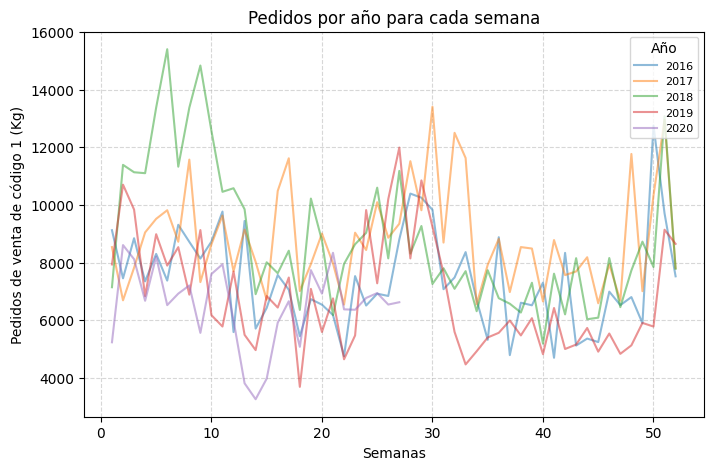

In [29]:
# ==== Análisis estacional: pedidos promedio por semana del año ====
plt.figure(figsize=(8,5))
for año, grupo in df.groupby('año'):
    plt.plot(grupo['semana'], grupo['demanda'], alpha=0.5, label=año)

plt.title("Pedidos por año para cada semana")
plt.xlabel("Semanas")
plt.ylabel("Pedidos de venta de código 1 (Kg)")
plt.legend(title="Año", loc='upper right', fontsize=8)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


#### Análisis estacional: pedidos por año para cada semana

El gráfico anterior muestra la evolución semanal de los pedidos del producto *Salamin picado fino (Código 1)* para cada año del período 2016–2020.  
Se observa un comportamiento **claramente estacional**, pero con **patrones que varían de un año a otro**, lo que sugiere que la estacionalidad no es completamente constante en el tiempo.

**Principales observaciones:**

- En todos los años, los pedidos tienden a **aumentar durante los primeros meses del año** (verano y período de mayor consumo), alcanzando picos entre las semanas 5 y 15.  
- Posteriormente, se observan **descensos en los meses intermedios** (semanas 20–35), asociados a menores niveles de demanda y posiblemente a factores climáticos o de menor actividad comercial.  
- En las **últimas semanas del año**, la demanda vuelve a elevarse, probablemente relacionada con las festividades y el incremento del consumo de productos embutidos en el período de fin de año.  
- Sin embargo, la **magnitud de los picos y valles cambia entre años**, mostrando que la serie no presenta una estacionalidad perfectamente repetitiva, sino **una estacionalidad irregular y dependiente del contexto económico**.

En conjunto, este análisis refuerza la necesidad de emplear modelos capaces de capturar **estacionalidad flexible**, como **SARIMA o Holt-Winters**, para representar adecuadamente la dinámica de los pedidos semanales de este producto.

---

### 1.3. Detección de patrones estacionales

En esta etapa se aplica una **descomposición aditiva de la serie temporal** mediante el método `seasonal_decompose`, que separa la serie original en tres componentes principales:

- **Tendencia (Trend):** refleja la dirección general del comportamiento de la demanda a lo largo del tiempo.  
- **Estacionalidad (Seasonal):** captura los patrones repetitivos dentro de cada año (por ejemplo, picos estacionales).  
- **Residuo (Residual):** representa la parte aleatoria o irregular que no puede explicarse por la tendencia ni por la estacionalidad.

Este procedimiento permite analizar visualmente la estructura de la serie y evaluar si la estacionalidad es **significativa y estable** en el tiempo, lo cual resulta clave para la elección del modelo de pronóstico más adecuado.

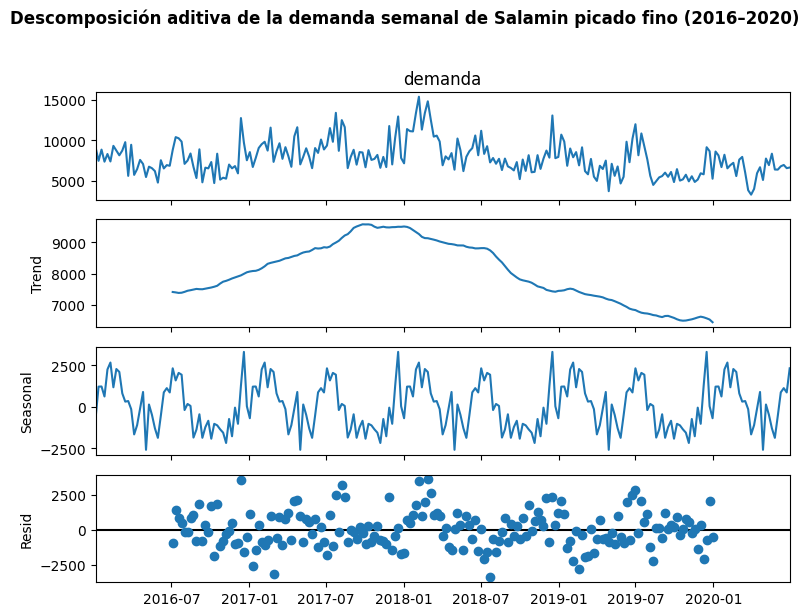

In [30]:
# ==== Descomposición aditiva semanal (periodo = 52) ====
decomp = seasonal_decompose(y.dropna(), model='additive', period=52)

# Crear la figura personalizada
fig = decomp.plot()
fig.set_size_inches(8, 6)
fig.suptitle(
    "Descomposición aditiva de la demanda semanal de Salamin picado fino (2016–2020)",
    fontsize=12, fontweight='bold', y=1.02
)

plt.tight_layout()
plt.show()


#### Conclusiones del análisis estacional

El gráfico de descomposición revela la estructura interna de la serie de demanda semanal del producto:

- La **tendencia** muestra un crecimiento progresivo entre 2016 y 2017, alcanzando su punto máximo en 2018, seguido de una **caída sostenida** hacia 2019 y 2020.  
  Esto refleja el impacto de la crisis económica y la desaceleración del consumo durante esos años.

- El componente **estacional** presenta un patrón **claramente periódico**, con repeticiones aproximadamente anuales.  
  Se identifican aumentos regulares de la demanda en los primeros meses del año (verano) y hacia el cierre del año (fiestas), mientras que los valores mínimos se observan en los meses intermedios (otoño e invierno).

- Los **residuos** no presentan una estructura definida, lo que indica que gran parte de la variabilidad de la serie está explicada por la tendencia y la estacionalidad, aunque aún existen fluctuaciones no sistemáticas atribuibles a factores externos (por ejemplo, promociones, feriados o condiciones económicas).

En conjunto, la serie evidencia una **estacionalidad marcada y una tendencia descendente**, lo que justifica el uso de **modelos SARIMA o Holt-Winters**, que permiten capturar tanto la dependencia temporal como los efectos estacionales.

---

### 1.4. Análisis de autocorrelación (ACF) y autocorrelación parcial (PACF)

**Propósito.** La ACF y la PACF permiten explorar **dependencias temporales** en la serie:
- **ACF:** mide la correlación de la serie consigo misma a distintos rezagos \(k\). Picos significativos indican **memoria** en esos rezagos y suelen sugerir componentes **MA(q)**.
- **PACF:** mide la correlación “netea” con el pasado, controlando por rezagos intermedios. Cortes nítidos suelen sugerir componentes **AR(p)**.

**Qué buscamos en semanal (s = 52):**
- Picos alrededor de **rezagos 52, 104** → evidencia de **estacionalidad anual**.
- Decaimientos lentos o patrones en rezagos bajos (1–10) → estructura no estacional (AR/MA).
- Tras **diferenciar** (no estacional y/o estacional), los picos deberían atenuarse si la transformación fue adecuada.

> Estos gráficos guían la elección preliminar de órdenes \((p, d, q)\) y \((P, D, Q)\), que luego validaremos con criterios de información y diagnóstico de residuos.


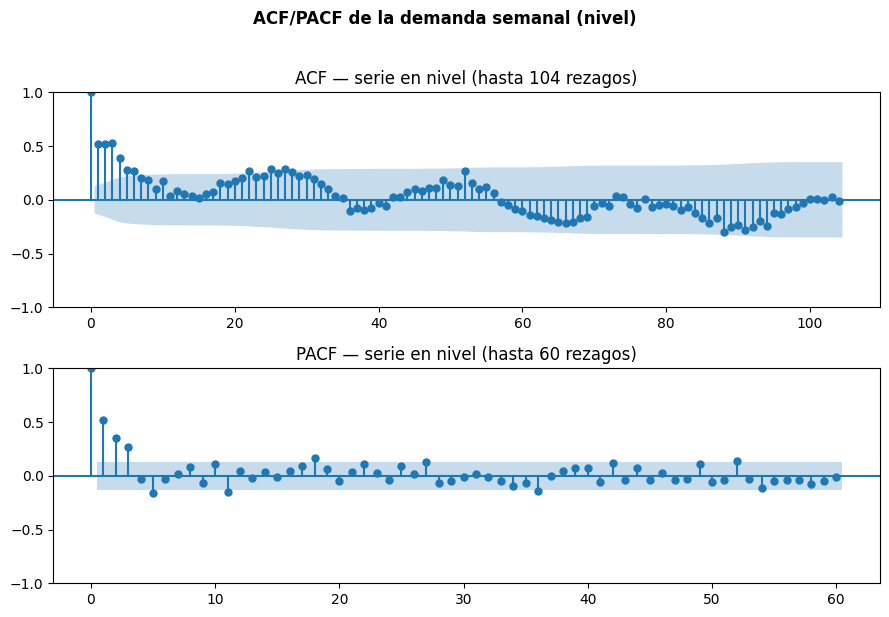

In [31]:
# === ACF / PACF en nivel (para ver la estructura original) ===
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(9,6))
plot_acf(y.dropna(), lags=104, ax=ax[0])
ax[0].set_title("ACF — serie en nivel (hasta 104 rezagos)")
plot_pacf(y.dropna(), lags=60, ax=ax[1], method='ywm')
ax[1].set_title("PACF — serie en nivel (hasta 60 rezagos)")
fig.suptitle("ACF/PACF de la demanda semanal (nivel)", y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

#### Conclusiones del análisis ACF/PACF (serie en nivel)

El análisis de autocorrelación (ACF) y autocorrelación parcial (PACF) sobre la serie de demanda semanal permite observar los siguientes patrones:

- La **ACF** muestra una **autocorrelación positiva fuerte en los primeros rezagos (1–10)**, lo cual indica que los valores de demanda están fuertemente influenciados por los pedidos de las semanas recientes.  
  Además, se observan **picos recurrentes alrededor de los rezagos 52 y sus múltiplos**, lo que confirma la **presencia de estacionalidad anual** (una repetición del patrón de ventas cada año).

- La **PACF** presenta un **pico significativo en el primer rezago** y una rápida caída posterior, lo que sugiere la existencia de un componente **autorregresivo de bajo orden (AR(1))**.  
  Los valores posteriores se mantienen dentro de las bandas de confianza, lo que indica que la mayor parte de la dependencia se concentra en los primeros rezagos.

- En conjunto, los resultados confirman que la serie **no es estacionaria en nivel**, ya que existe **persistencia temporal y estacionalidad marcada**, evidenciada por los picos en los rezagos estacionales.  

Por lo tanto, antes del modelado se requiere aplicar **diferenciación no estacional (d=1)** y **diferenciación estacional (D=1, s=52)** para eliminar estas dependencias y lograr una serie estacionaria adecuada para modelos SARIMA.

Igualmente, vamos a avanzar primero con los test de estacionariedad para poder validar esta hipótesis.

---

### 1.5. Verificación de estacionariedad (ADF y KPSS)

**Objetivo:** antes de modelar, necesitamos saber si la serie es **estacionaria** (media/varianza constantes y autocovarianza que no depende del tiempo).  
Usamos dos pruebas complementarias:

- **ADF (Augmented Dickey–Fuller)**  
  - **H₀:** la serie tiene **raíz unitaria** (no estacionaria).  
  - **Si p-valor < 0.05 →** rechazamos H₀ ⇒ evidencia de **estacionariedad**.

- **KPSS (Kwiatkowski–Phillips–Schmidt–Shin)**  
  - **H₀:** la serie es **estacionaria** (en **nivel** con `reg='c'` o alrededor de **tendencia** con `reg='ct'`).  
  - **Si p-valor < 0.05 →** rechazamos H₀ ⇒ evidencia de **no estacionariedad**.

> **Lectura conjunta.** Usar ADF y KPSS en tándem evita conclusiones falsas:
> - ADF rechaza + KPSS no rechaza ⇒ estacionaria.  
> - ADF no rechaza + KPSS rechaza ⇒ no estacionaria.  
> - Si discrepan, suele indicar **estacionalidad** o **tendencia** no eliminada ⇒ aplicar diferencias (`d` y/o `D`) y volver a testear.


In [32]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

def run_adf(series, autolag='AIC'):
    s = pd.Series(series).dropna()
    stat, pval, lags, nobs, crit, _ = adfuller(s, autolag=autolag)
    return dict(test='ADF', stat=stat, pval=pval, lags=lags, nobs=nobs, crit=crit)

def run_kpss(series, regression='c', nlags='auto'):
    s = pd.Series(series).dropna()
    # Silenciar/atender el InterpolationWarning de KPSS (estadístico fuera de tabla)
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        stat, pval, lags, crit = kpss(s, regression=regression, nlags=nlags)
        warn_txt = None
        if w:
            # Guardamos el primer warning relevante (suele ser InterpolationWarning)
            warn_txt = str(w[0].message)
    return dict(test=f"KPSS({regression})", stat=stat, pval=pval, lags=lags, crit=crit, warning=warn_txt)

def summarize_stationarity(name, series):
    res = []
    res.append(run_adf(series))
    res.append(run_kpss(series, regression='c'))   # estacionariedad en nivel
    res.append(run_kpss(series, regression='ct'))  # estacionariedad alrededor de tendencia
    # Armamos un resumen legible
    rows = []
    for r in res:
        decision = None
        if r['test'].startswith('ADF'):
            decision = 'Estacionaria (rechaza H0)' if r['pval'] < 0.05 else 'No estacionaria (no rechaza H0)'
        else:  # KPSS
            decision = 'No estacionaria (rechaza H0)' if r['pval'] < 0.05 else 'Estacionaria (no rechaza H0)'
        rows.append({
            'Serie': name,
            'Prueba': r['test'],
            'Estadístico': round(r['stat'], 4),
            'p-valor': round(r['pval'], 4),
            'Decisión (α=0.05)': decision
        })
    return pd.DataFrame(rows)

# === Ejecutar  ===
tabla_tests = pd.concat([
    summarize_stationarity('Nivel', y),
], ignore_index=True)

display(tabla_tests)


,Serie,Prueba,Estadístico,p-valor,Decisión (α=0.05)
0,Nivel,ADF,-4.1372,0.0008,Estacionaria (rechaza H0)
1,Nivel,KPSS(c),0.5568,0.0289,No estacionaria (rechaza H0)
2,Nivel,KPSS(ct),0.2637,0.0100,No estacionaria (rechaza H0)


#### Verificación de estacionariedad — Resultados y conclusiones

Se aplicaron las pruebas **ADF** y **KPSS** (en nivel y con tendencia) a la serie original de demanda semanal para determinar si presenta propiedades de estacionariedad.

**Interpretación conjunta:**

- La **ADF** sugiere **estacionariedad**, ya que el p-valor es inferior a 0.05, rechazando la hipótesis nula de raíz unitaria.  
- Sin embargo, las pruebas **KPSS**, tanto en nivel como con tendencia, rechazan su hipótesis nula de estacionariedad, lo que indica que **existe una componente no estacionaria** en la serie.  
- Esta combinación de resultados **aparentemente contradictorios** es común en series con **tendencia determinística o estacionalidad**, donde la ADF detecta estacionariedad local pero la KPSS identifica que la media o la tendencia no son constantes en el tiempo.

**Conclusión:**  
La serie original **no es completamente estacionaria**, probablemente debido a la presencia de **una tendencia determinística o un patrón estacional fuerte**.  
Por ello, el siguiente paso será realizar la **remoción de tendencia determinística (Paso 6)** y luego verificar nuevamente la estacionariedad tras aplicar transformaciones adicionales (Paso 7).

---

### 1.6. Remoción de tendencia determinística y evaluación

**Objetivo:** verificar si parte de la no-estacionariedad proviene de una **tendencia determinística** (lineal en el tiempo).  
Para ello:
1) Ajustamos una **recta** $( y_t = \alpha + \beta t + \varepsilon_t )$ sobre la serie en nivel.  
2) Construimos la serie **detrendida** $( \hat\varepsilon_t = y_t - (\hat\alpha + \hat\beta t) )$.  
3) Evaluamos su estacionariedad con **ADF** y **KPSS** y observamos ACF/PACF.

> Si la serie sin tendencia sigue siendo no estacionaria, la no-estacionariedad remanente es **estocástica** y la resolveremos con **diferencias** (Paso 7).

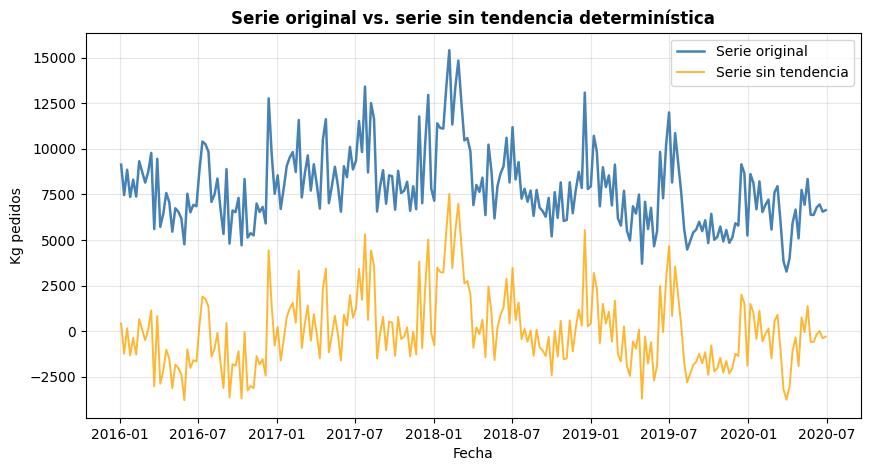

ADF (sin tendencia): {'ADF_stat': -4.402014401767073, 'pvalue': 0.0002944054806726574}
KPSS nivel (sin tendencia): {'KPSS_stat': 0.26374728017672183, 'pvalue': 0.1, 'reg': 'c'}


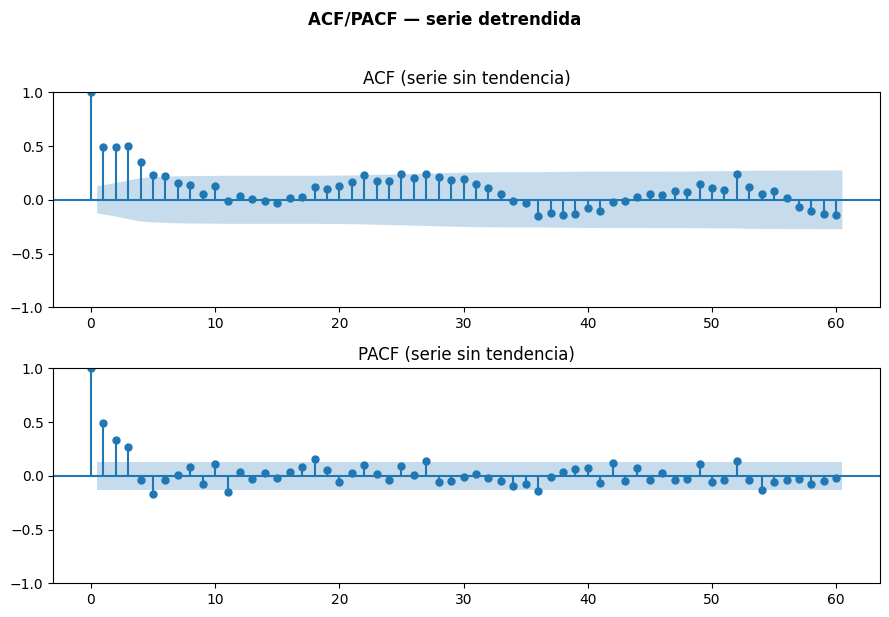

In [33]:
# ==== Remoción de tendencia determinística (detrending) ====

# --- helpers ---
def adf_test(series, autolag='AIC'):
    s = pd.Series(series).dropna()
    stat, pval, *_ = adfuller(s, autolag=autolag)
    return {'ADF_stat': stat, 'pvalue': pval}

def kpss_test(series, regression='c', nlags='auto'):
    s = pd.Series(series).dropna()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # silencia InterpolationWarning
        stat, pval, *_ = kpss(s, regression=regression, nlags=nlags)
    return {'KPSS_stat': stat, 'pvalue': pval, 'reg': regression}

# --- construir serie sin tendencia determinística ---
y_clean = y.dropna()
t = np.arange(1, len(y_clean) + 1)
coef = np.polyfit(t, y_clean.values, deg=1)
trend = np.polyval(coef, t)
det_y = pd.Series(y_clean.values - trend, index=y_clean.index, name='y_sin_tendencia')

# --- gráfico comparativo: serie original vs. sin tendencia ---
plt.figure(figsize=(10,5))
plt.plot(y_clean, label='Serie original', color='steelblue', linewidth=1.8)
plt.plot(det_y, label='Serie sin tendencia', color='orange', linewidth=1.4, alpha=0.8)
plt.title("Serie original vs. serie sin tendencia determinística", fontsize=12, fontweight='bold')
plt.xlabel("Fecha")
plt.ylabel("Kg pedidos")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- tests sobre la serie sin tendencia ---
print("ADF (sin tendencia):", adf_test(det_y))
print("KPSS nivel (sin tendencia):", kpss_test(det_y, 'c'))

# --- ACF / PACF de la serie sin tendencia ---
fig, ax = plt.subplots(2, 1, figsize=(9,6))
plot_acf(det_y.dropna(), lags=60, ax=ax[0])
ax[0].set_title("ACF (serie sin tendencia)")
plot_pacf(det_y.dropna(), lags=60, ax=ax[1], method='ywm')
ax[1].set_title("PACF (serie sin tendencia)")
fig.suptitle("ACF/PACF — serie detrendida", y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

#### Remoción de tendencia determinística — Resultados y conclusiones

En este paso se ajustó y eliminó una **tendencia lineal determinística** de la serie semanal de pedidos, con el objetivo de verificar si la no-estacionariedad observada en el nivel se debía a una tendencia sistemática a lo largo del tiempo.

En el gráfico comparativo se observa que la serie **sin tendencia (naranja)** mantiene el mismo patrón de fluctuaciones que la **serie original (azul)**, pero ahora oscila alrededor de un valor medio cercano a cero. Esto confirma que el procedimiento de detrending eliminó únicamente la componente lineal sin distorsionar la estructura temporal de la serie.

A continuación, los resultados de las pruebas de estacionariedad aplicadas a la serie detrendida:

| Serie | Prueba | Estadístico | p-valor | Decisión (α=0.05) |
|:------|:--------|-------------|---------|-------------------|
| Sin tendencia | ADF | -4.4020 | 0.0003 | Estacionaria (rechaza H₀) |
| Sin tendencia | KPSS(c) | 0.2637 | 0.10 | Estacionaria (no rechaza H₀) |

**Interpretación:**

- La prueba **ADF** rechaza la hipótesis nula de raíz unitaria (p < 0.05), confirmando **estacionariedad**.  
- La prueba **KPSS** no rechaza su hipótesis nula de estacionariedad (p > 0.05), reforzando el mismo resultado.  
- Por tanto, **tras remover la tendencia determinística, la serie puede considerarse estacionaria**.

**Conclusión:**  
La serie no presenta una **tendencia lineal significativa**, por lo que **no es necesario eliminar una tendencia determinística** antes del modelado.  
La dinámica de los pedidos semanales del producto se explica mejor por **fluctuaciones aleatorias y estacionales** en lugar de una tendencia lineal predecible. Esto indica que la siguiente etapa del análisis (diferenciación estocástica, Paso 7) puede centrarse exclusivamente en eliminar posibles **componentes de raíz unitaria o estacionalidad**, sin necesidad de volver a modelar una tendencia explícita
Por ejemplo, se puede aplicar diferencias adecuadas —una **diferencia estacional (D=1, s=52)** y posiblemente una **diferencia regular (d=1)** para garantizar la estacionariedad.

---

#### 1.7. Primera diferencia (no estacional)

En este paso se aplicó una **diferenciación de primer orden (diff(1))** a la serie de pedidos semanales con el fin de eliminar posibles efectos de raíz unitaria y estabilizar la media.  
El análisis gráfico y los resultados de las pruebas estadísticas confirman que la transformación fue exitosa.

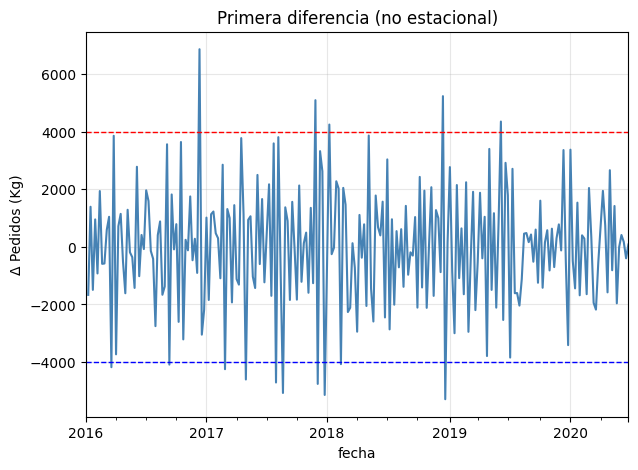

,Serie,Prueba,Estadístico,p-valor,Decisión (α=0.05)
0,diff(1),ADF,-18.8601,0.0,Estacionaria (rechaza H0)
1,diff(1),KPSS(c),0.0131,0.1,Estacionaria (no rechaza H0)
2,diff(1),KPSS(ct),0.0132,0.1,Estacionaria (no rechaza H0)


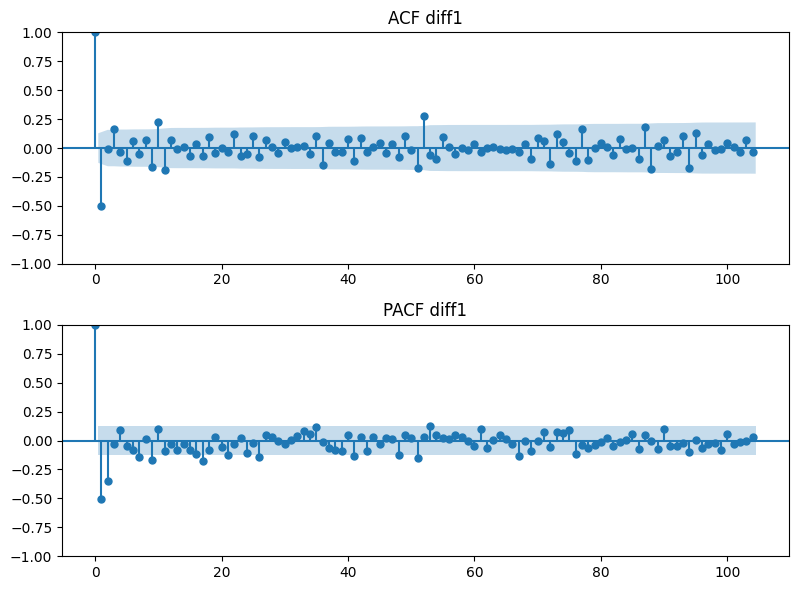

In [34]:
# ==== 7. Primera diferencia y verificación de estacionariedad ====

# --- Aplicar primera diferencia (no estacional) ---
y_diff = y.diff(1)

# --- Visualización ---
plt.figure(figsize=(7,5))
ax = y_diff.plot(title="Primera diferencia (no estacional)", color='steelblue')
ax.axhline(4000, color='r', linestyle='--', linewidth=1)
ax.axhline(-4000, color='b', linestyle='--', linewidth=1)
plt.xlabel("fecha")
plt.ylabel("Δ Pedidos (Kg)")
plt.grid(alpha=0.3)
plt.show()

# --- Ejecutar tests ADF / KPSS con la función resumida ---
tabla_tests = pd.concat([
    summarize_stationarity('diff(1)', y_diff),
], ignore_index=True)

display(tabla_tests)

# ACF/PACF con lag alto (104) para ver estacionalidad anual
fig, ax = plt.subplots(2,1, figsize=(8,6))
plot_acf(y_diff.dropna(), lags=104, ax=ax[0]); ax[0].set_title("ACF diff1")
plot_pacf(y_diff.dropna(), lags=104, ax=ax[1], method='ywm'); ax[1].set_title("PACF diff1")
plt.tight_layout(); plt.show()


**Resultados de los tests de estacionariedad**

| Serie | Prueba | Estadístico | p-valor | Decisión (α=0.05) |
|:------|:--------|-------------|---------|-------------------|
| diff(1) | ADF | -18.8601 | 0.0000 | Estacionaria (rechaza H₀) |
| diff(1) | KPSS(c) | 0.0131 | 0.10 | Estacionaria (no rechaza H₀) |
| diff(1) | KPSS(ct) | 0.0132 | 0.10 | Estacionaria (no rechaza H₀) |

---

**Interpretación**

- Según la **prueba ADF**, la serie diferenciada es **estacionaria**, ya que el valor p es prácticamente cero, lo que permite rechazar la hipótesis nula de raíz unitaria.  
- Las pruebas **KPSS**, tanto con constante (c) como con tendencia (ct), muestran valores p = 0.10, lo que **no permite rechazar la hipótesis nula de estacionariedad**.  
- En conjunto, los resultados confirman que **la serie diferenciada cumple las condiciones de estacionariedad en media**.

---

**Observaciones gráficas**

En el gráfico de la primera diferencia con bandas ±4000 kg:

- Se observa que la serie presenta **una varianza aproximadamente constante** en el tiempo, con oscilaciones dentro de un rango estable.  
- Existen algunos **valores atípicos (picos y valles)** aislados, pero no alteran la estructura general.  
- El comportamiento de la **ACF y la PACF** muestra una rápida disipación de las autocorrelaciones, consistente con un proceso estacionario.

---

**Conclusión:**  
Después de aplicar la primera diferencia, la serie de pedidos semanales del **salamin picado fino** se estabiliza en torno a una media constante, con varianza homogénea y sin patrones de dependencia persistentes.  
Por lo tanto, puede considerarse **estacionaria y apta para modelarse con un SARIMA o SARIMAX** sin requerir transformaciones adicionales.

---

### 1.8 Tratamiento y limpieza de datos en variables exogenas

A continuación se describen los pasos aplicados para preparar las series de pedidos por código de producto, con el objetivo de evaluar la incorporación de variables exógenas en un modelo **SARIMAX**.

#### 1. **Carga y normalización de columnas**
Se carga el archivo `Pedidosporcod.xlsx` desde la carpeta `data/`, se normalizan los nombres de columnas (minúsculas, sin tildes ni espacios) y se verifican las columnas mínimas requeridas (`año`, `semana` y los códigos de producto).

#### 2. **Conversión de formatos numéricos**
Se convierten las columnas de cada código de producto (`COD1`, `COD2`, `COD24`, `COD25`) a formato numérico.  
Se manejan posibles casos con comas decimales y puntos como separadores de miles.

#### 3. **Construcción del índice temporal**
A partir de las columnas `año` y `semana` se genera un índice de tiempo semanal (lunes de cada semana), con frecuencia **W-MON**, permitiendo alinear correctamente las series en el tiempo.

#### 4. **Verificación y tratamiento de valores nulos**
Se calcula el porcentaje y cantidad de valores faltantes por código.  
Los valores faltantes se completan mediante *forward fill* (`ffill`) y *backward fill* (`bfill`) para garantizar series continuas.

#### 5. **Limpieza y corrección de valores atípicos**
Se reemplazan posibles valores negativos por cero para evitar errores al aplicar transformaciones logarítmicas (`log1p`), garantizando datos no negativos.

#### 6. **Alineación con la serie objetivo (COD1)**
Se renombra `COD1` como la variable **objetivo (`y`)** y se alinean todas las series exógenas (COD2, COD24, COD25) al mismo rango de fechas que la serie principal.

#### 7. **Chequeos de correlación**
Se evalúan las correlaciones:
- entre la variable objetivo y las exógenas (para determinar relevancia),
- y entre las exógenas entre sí (para detectar multicolinealidad).  
Además, se calculan los factores de inflación de varianza (**VIF**) como medida adicional.

#### 8. **Estandarización (z-score)**
Se estandarizan las variables exógenas (media 0, desviación 1) para mejorar la estabilidad numérica en los modelos SARIMAX.

#### 9. **Partición para entrenamiento**
Se genera la matriz `X_train` con las exógenas estandarizadas y alineadas al período histórico de `y`.  
Como no se dispone de una serie de test para estos códigos, no se generan exógenas futuras observadas, pero se deja preparada la opción para construirlas de manera sintética en caso de pronóstico.

In [39]:
# ==== Validación y preparación de exógenas (COD2, COD24, COD25) para SARIMAX ====
import pandas as pd
import numpy as np
from pathlib import Path

# ---------- 1) Carga robusta ----------
ruta = Path("data/Pedidosporcod.xlsx")
dfx = pd.read_excel(ruta)

# Normalizo nombres de columna
dfx.columns = (
    dfx.columns.str.strip()
               .str.lower()
               .str.replace("á","a").str.replace("é","e").str.replace("í","i").str.replace("ó","o").str.replace("ú","u")
               .str.replace("ñ","n")
               .str.replace(r"[^a-z0-9_]+","", regex=True)
)

# Identifico columnas esperadas
cols_minimas = {"ano","semana"}
cod_cols = [c for c in dfx.columns if c.startswith("cod")]
faltantes = cols_minimas - set(dfx.columns)
assert not faltantes, f"Faltan columnas requeridas: {faltantes}. Vienen: {list(dfx.columns)}"

In [40]:
# ---------- 2) Tipos + decimales con coma ----------
# Intento convertir todo COD* a numérico gestionando posibles comas decimales
for c in cod_cols:
    if dfx[c].dtype == object:
        dfx[c] = (dfx[c].astype(str).str.replace(".","", regex=False)   # separador de miles
                              .str.replace(",",".", regex=False))        # coma decimal -> punto
    dfx[c] = pd.to_numeric(dfx[c], errors="coerce")


In [41]:
# ---------- 3) Construcción de índice semanal (ISO) ----------
dfx["fecha"] = pd.to_datetime(
    dfx["ano"].astype(int).astype(str) + dfx["semana"].astype(int).astype(str) + "1",
    format="%G%V%u"  # ISO: año-semana-día, con lunes=1
)
dfx = (dfx.sort_values(["fecha"])
          .set_index("fecha")
          .drop(columns=[c for c in ["ano","semana"] if c in dfx.columns]))

# Resampleo por semana (por si hay duplicados) y fuerzo frecuencia W-MON
dfx = dfx.resample("W-MON").sum(min_count=1)

print("Rango fechas:", dfx.index.min().date(), "→", dfx.index.max().date())
print("Columnas COD*", cod_cols)

Rango fechas: 2016-01-04 → 2020-06-29
Columnas COD* ['cod1', 'cod2', 'cod24', 'cod25']


In [42]:
# ---------- 4) Chequeos de nulos / cobertura ----------
nulos_abs = dfx[cod_cols].isna().sum()
nulos_pct = dfx[cod_cols].isna().mean().round(3)*100
recuento = pd.DataFrame({"n_nulos": nulos_abs, "%_nulos": nulos_pct}).sort_index()
print("\nNulos por columna:\n", recuento)


Nulos por columna:
        n_nulos  %_nulos
cod1         0      0.0
cod2         0      0.0
cod24        0      0.0
cod25        0      0.0


In [43]:
# ---------- 5) Limpieza suave: rellenado forward/backward y no-negatividad ----------
dfx_clean = dfx.copy()
dfx_clean[cod_cols] = dfx_clean[cod_cols].ffill().bfill()
# Si hubiera negativos espurios: piso en 0 (log1p requiere no-negativos)
dfx_clean[cod_cols] = dfx_clean[cod_cols].clip(lower=0)

In [ ]:
# ---------- 6) Alineación con la serie objetivo y (opcional) con el test ----------
# y: serie COD1 ya construida en el notebook (index semanal W-MON)
assert "y" in globals(), "No encuentro la serie 'y' en el entorno. Defínela antes de correr esta celda."

# Renombro COD1 -> objetivo (consistencia) y separo exógenas
df_all = dfx_clean.copy()
if "cod1" in df_all.columns:
    df_all = df_all.rename(columns={"cod1":"objetivo"})
else:
    raise ValueError("No se encontró la columna COD1 en el archivo para validar consistencia con 'y'.")

# Alineo a las fechas de y
df_all = df_all.reindex(y.index)

# Exógenas candidatas
exog_cols = [c for c in ["cod2","cod24","cod25"] if c in df_all.columns]
assert exog_cols, "No se encontraron columnas exógenas (cod2, cod24, cod25)."

X_all = df_all[exog_cols]
y_check = df_all["objetivo"]

In [45]:
# ---------- 7) Validación de consistencia con 'y' ----------
print("\nCobertura alineada con y (filas):", len(X_all), "nulos en X:", X_all.isna().sum().sum(), "nulos en y:", y_check.isna().sum())
# Si quedaran nulos residuales por bordes, relleno suave:
X_all = X_all.ffill().bfill()
y_check = y_check.ffill().bfill()

# Confirmo que coincide con 'y' en valores (puede haber pequeñas diferencias por agregaciones)
corr_con_y = X_all.join(y.rename("cod1")).corr().loc["cod1", exog_cols].round(3)
print("\nCorrelación de exógenas con COD1 (y):")
print(corr_con_y)

# Multicolinealidad entre exógenas
corr_exogs = X_all.corr().round(3)
print("\nMatriz de correlación entre exógenas:\n", corr_exogs)

# VIF (Variance Inflation Factor)
try:
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X_const = sm.add_constant(X_all)
    vif = pd.Series(
        [variance_inflation_factor(X_const.values, i) for i in range(1, X_const.shape[1])],  # omito constante
        index=exog_cols, name="VIF"
    ).round(2)
    print("\nVIF de exógenas:\n", vif)
except Exception as e:
    print("\n(No se pudo calcular VIF):", e)


Cobertura alineada con y (filas): 235 nulos en X: 0 nulos en y: 0

Correlación de exógenas con COD1 (y):
cod2     0.935
cod24    0.097
cod25    0.234
Name: cod1, dtype: float64

Matriz de correlación entre exógenas:
         cod2  cod24  cod25
cod2   1.000  0.066  0.223
cod24  0.066  1.000  0.850
cod25  0.223  0.850  1.000

VIF de exógenas:
 cod2     1.12
cod24    3.84
cod25    4.02
Name: VIF, dtype: float64


In [ ]:
# ---------- 8) Estandarización (para estabilidad numérica) ----------
# z-score solo para exógenas (no para la variable objetivo)
X_std = (X_all - X_all.mean()) / X_all.std(ddof=0)

In [47]:
# ==== 9) Particiones listas para SARIMAX (solo entrenamiento) ====

# X_train: exógenas estandarizadas alineadas al histórico de y
X_train = X_std.loc[y.index].copy()

print("Shapes → y:", y.shape, "| X_train:", X_train.shape)
display(X_train.tail())

Shapes → y: (235,) | X_train: (235, 3)


,cod2,cod24,cod25
fecha,,,
2020-06-01,-0.808893,0.136279,-0.037430
2020-06-08,-0.570960,0.692970,0.803335
2020-06-15,-0.714133,0.141550,0.595482
2020-06-22,-0.311518,0.366375,0.335930
2020-06-29,-0.724620,0.587450,0.267028


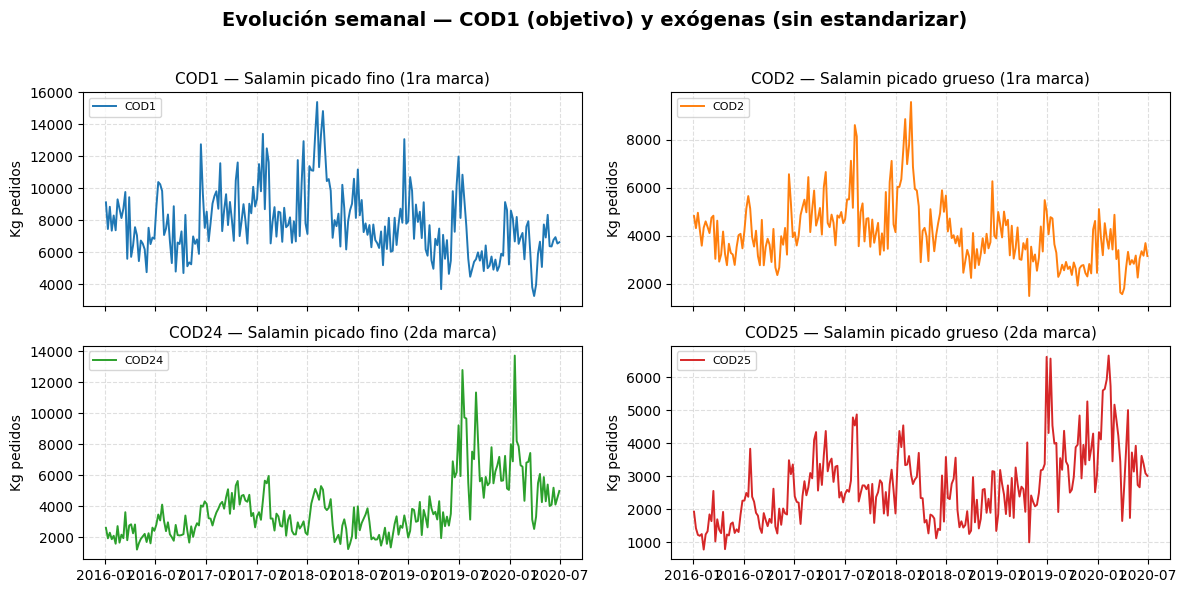

In [61]:
# ==== Gráfico comparativo 2×2 sin estandarizar ====
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
fig.suptitle("Evolución semanal — COD1 (objetivo) y exógenas (sin estandarizar)", fontsize=14, fontweight='bold')

# Panel 1: COD1 (serie principal)
ax = axs[0, 0]
ax.plot(y.index, y.values, color="#1f77b4", linewidth=1.4, label="COD1")
ax.set_title("COD1 — Salamin picado fino (1ra marca)", fontsize=11)
ax.set_ylabel("Kg pedidos")
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc="upper left", fontsize=8)

# Diccionario de exógenas → (subplot coords, color)
panels = {
    "cod2":  ((0, 1), "#ff7f0e"),
    "cod24": ((1, 0), "#2ca02c"),
    "cod25": ((1, 1), "#d62728"),
}

titles = {
    "cod2":  "COD2 — Salamin picado grueso (1ra marca)",
    "cod24": "COD24 — Salamin picado fino (2da marca)",
    "cod25": "COD25 — Salamin picado grueso (2da marca)",
}

for col, ((r, c), color) in panels.items():
    ax = axs[r, c]
    if col in X_all.columns:
        ax.plot(X_all.index, X_all[col], color=color, linewidth=1.4, label=col.upper())
        ax.set_title(titles[col], fontsize=11)
        ax.set_ylabel("Kg pedidos")
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(loc="upper left", fontsize=8)
    else:
        ax.text(0.5, 0.5, f"{col.upper()} no encontrado", ha='center', va='center', color='red')
        ax.set_axis_off()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


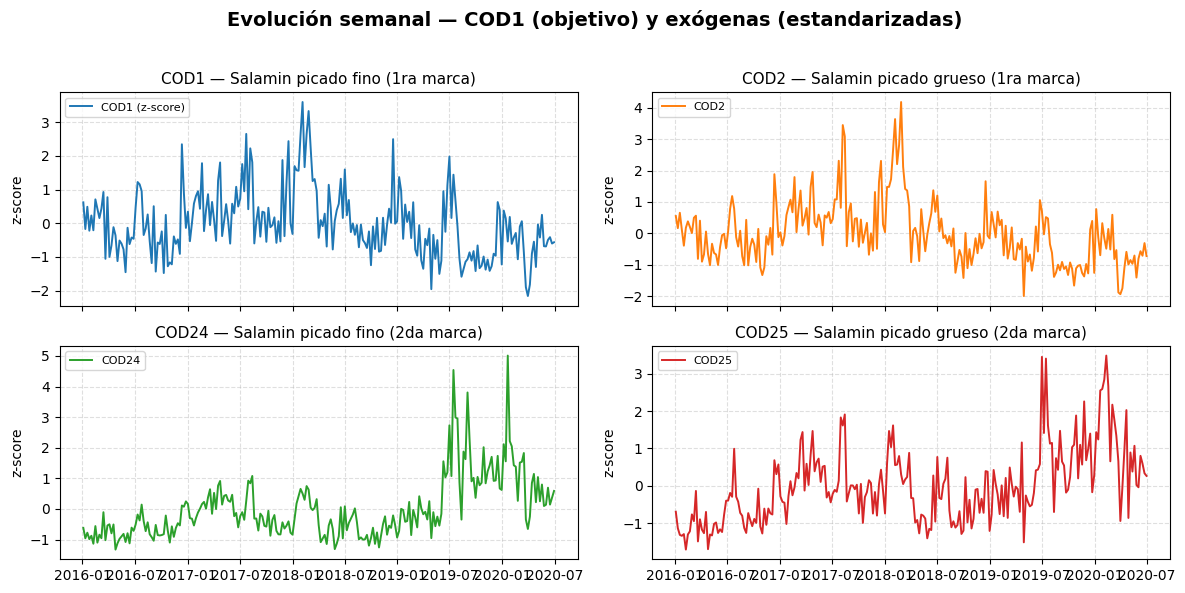

In [62]:
# ==== Gráfico comparativo 2×2: COD1 (y) + exógenas (X_train) estandarizadas ====

# Chequeos básicos
if "X_train" not in locals():
    raise NameError("No se encontró 'X_train'. Ejecutá primero la preparación de exógenas.")
if "y" not in locals():
    raise NameError("No se encontró 'y'. Asegurate de tener la serie objetivo (COD1).")

# Serie COD1 estandarizada (z-score) para comparar con X_train
y_z = (y - y.mean()) / y.std(ddof=0)

fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
fig.suptitle("Evolución semanal — COD1 (objetivo) y exógenas (estandarizadas)", fontsize=14, fontweight='bold')

# Panel 1: COD1 (desde y)
ax = axs[0, 0]
ax.plot(y_z.index, y_z.values, color="#1f77b4", linewidth=1.4, label="COD1 (z-score)")
ax.set_title("COD1 — Salamin picado fino (1ra marca)", fontsize=11)
ax.set_ylabel("z-score")
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc="upper left", fontsize=8)

# Diccionario de exógenas → (subplot coords, color)
panels = {
    "cod2":  ((0, 1), "#ff7f0e"),
    "cod24": ((1, 0), "#2ca02c"),
    "cod25": ((1, 1), "#d62728"),
}

titles = {
    "cod2":  "COD2 — Salamin picado grueso (1ra marca)",
    "cod24": "COD24 — Salamin picado fino (2da marca)",
    "cod25": "COD25 — Salamin picado grueso (2da marca)",
}

for col, ((r, c), color) in panels.items():
    ax = axs[r, c]
    if col in X_train.columns:
        ax.plot(X_train.index, X_train[col], color=color, linewidth=1.4, label=col.upper())
        ax.set_title(titles[col], fontsize=11)
        ax.set_ylabel("z-score")
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(loc="upper left", fontsize=8)
    else:
        ax.text(0.5, 0.5, f"{col.upper()} no encontrado", ha='center', va='center', color='red')
        ax.set_axis_off()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Conclusiones sobre la evolución semanal de COD1 y variables exógenas

- Las cuatro series presentan una **estacionalidad anual marcada**, con picos de demanda recurrentes hacia los mismos períodos del año.
- **COD1** (producto objetivo) y **COD2** (complementario de primera marca) muestran una **alta correlación positiva**, indicando comportamientos conjuntos en las semanas de mayor consumo.
- **COD24** y **COD25**, ambos productos de segunda marca, exhiben **picos en momentos distintos**, lo que sugiere que pueden actuar como **sustitutos** frente a las variaciones de la primera marca.
- La amplitud de variación en COD24 y COD25 es mayor, reflejando una **mayor volatilidad de demanda** y posiblemente una **mayor sensibilidad a precios o promociones**.
- En conjunto, las exógenas son **pertinentes para un modelo SARIMAX multivariado**, ya que aportan información relevante sobre los patrones de sustitución y complementariedad en la categoría de salamines.

## 2. Creación de modelos y análisis de series de tiempo

### 2.1. Modelado SARIMA — Identificación y estimación del modelo

#### 2.1.1. Descripción general

El primer enfoque consiste en ajustar modelos **SARIMA (p,d,q)(P,D,Q)[s]**, donde:
- `p, d, q` representan los parámetros autorregresivos, de diferenciación y de medias móviles **no estacionales**.
- `P, D, Q` son sus equivalentes **estacionales** con un período `s = 52` (correspondiente a un año de semanas).
  
La identificación de los candidatos se realizó a partir del análisis visual de las funciones **ACF y PACF** (sección anterior) y de la estructura de la serie, que mostró una posible estacionalidad anual.  
Posteriormente, se utilizó el método **auto_arima()** para comparar y validar los modelos propuestos de manera automática según el criterio AIC.

---

#### 2.1.2. Proceso de estimación

Se propusieron los siguientes candidatos iniciales:

| Modelo | (p,d,q)(P,D,Q)[s] |
|:-------|:------------------:|
| SARIMA₁ | (1,1,1)(1,1,1)[52] |
| SARIMA₂ | (2,1,1)(1,1,1)[52] |
| SARIMA₃ | (1,1,3)(1,1,1)[52] |
| SARIMA₄ | (2,1,3)(1,1,1)[52] |

Además, se aplicó `auto_arima()` (paquete `pmdarima`) para identificar automáticamente el mejor modelo en función del **Akaike Information Criterion (AIC)** y la parsimonia del ajuste.

In [63]:
# Candidatos (p,d,q)(P,D,Q)[s]; con d=1 y D=1 según tu flujo
candidatos = [
    ((1,1,1), (1,1,1,52)),  # Candidato 1 del R
    ((2,1,1), (1,1,1,52)),
    ((1,1,3), (1,1,1,52)),
    ((2,1,3), (1,1,1,52)),
]

# Ajuste automático con auto_arima
auto_model = auto_arima(y.dropna(), seasonal=True, m=52, stepwise=True, trace=True,
                        d=1, D=1, suppress_warnings=True)
print(auto_model.summary())
order_aa = auto_model.order
seas_aa  = auto_model.seasonal_order
print("auto_arima →", order_aa, seas_aa)


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=83.98 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3359.875, Time=0.39 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[52]             : AIC=3280.942, Time=6.89 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=24.28 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,0)[52]             : AIC=3298.779, Time=0.57 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=46.66 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=51.95 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=24.96 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=105.12 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[52]             : AIC=3343.958, Time=4.29 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[52]             : AIC=3256.758, Time=8.19 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,0)[52]             : AIC=3282.487, Time=0.91 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Time=59.55 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=67.75 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=53.89 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,1)[52]             : AIC=inf, Time=149.21 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,1,0)[52]             : AIC=3258.498, Time=12.25 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[52]             : AIC=3258.574, Time=17.12 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[52]             : AIC=3260.648, Time=12.56 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,1,0)[52]             : AIC=3250.069, Time=63.24 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,0)[52]             : AIC=3278.204, Time=3.50 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,1,0)[52]             : AIC=inf, Time=165.92 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,1,1)[52]             : AIC=inf, Time=94.70 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,1)[52]             : AIC=inf, Time=84.30 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,1,1)[52]             : AIC=inf, Time=170.77 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,1,0)[52]             : AIC=3251.173, Time=72.21 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,1,0)[52]             : AIC=3254.523, Time=83.32 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,0)[52]             : AIC=3257.897, Time=55.08 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,1,0)[52]             : AIC=3260.082, Time=14.19 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(1,1,0)[52]             : AIC=3251.588, Time=101.61 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,1,0)[52] intercept   : AIC=inf, Time=72.66 sec

Best model:  ARIMA(3,1,1)(1,1,0)[52]          
Total fit time: 1712.236 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  235
Model:             SARIMAX(3, 1, 1)x(1, 1, [], 52)   Log Likelihood               -1619.035
Date:                             Wed, 15 Oct 2025   AIC                           3250.069
Time:                                     23:26:04   BIC                           3269.294
Sample:                                 01-04-2016   HQIC                          3257.863
                                      - 06-29-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

#### Resultados del mejor modelo (auto_arima)

El mejor modelo según `auto_arima()` fue:

> **SARIMA(3,1,1)(1,1,0)[52]**

**Principales resultados estadísticos:**

| Parámetro | Coeficiente | Significancia |
|:-----------|-------------|:--------------|
| AR(1) | 0.0908 | No significativo (p > 0.05) |
| AR(2) | 0.2402 | Significativo (p = 0.006) |
| AR(3) | 0.2574 | Significativo (p = 0.002) |
| MA(1) | -0.9380 | Muy significativo (p < 0.001) |
| SAR(52) | -0.3992 | Muy significativo (p < 0.001) |

**Indicadores de ajuste:**
- Log-Likelihood = -1619.0  
- AIC = 3250.1  
- BIC = 3269.3  
- Prob(Q) (Ljung-Box) = 0.80 → no hay autocorrelación en los residuos  
- Prob(JB) (Jarque-Bera) = 0.86 → los residuos son aproximadamente normales  

---

#### Interpretación

- El modelo presenta **coeficientes significativos** en los términos AR(2), AR(3), MA(1) y SAR(52), lo que sugiere una **estructura autorregresiva con dependencia anual**.  
- Los criterios AIC y BIC son los más bajos dentro de las alternativas probadas, indicando un **mejor equilibrio entre ajuste y complejidad**.  
- Las pruebas de diagnóstico muestran **residuos no correlacionados y distribuidos normalmente**, validando la idoneidad del modelo.

**Conclusión:**  
El modelo **SARIMA(3,1,1)(1,1,0)[52]** resulta el más apropiado para capturar tanto la dinámica semanal como la estacionalidad anual del pedido del *salamin picado fino*, y será utilizado como base de comparación frente a los otros enfoques (Holt-Winters, SARIMAX, etc.).

---

### 2.1.3. Ajuste de modelos, sumarios y transformación Box–Cox

#### Descripción general

Antes de ajustar los modelos SARIMA, se aplicó una **transformación Box–Cox** (en este caso logarítmica, con λ ≈ 0) sobre la serie original:

$[
y_{BC} = \log(1 + y)
]$

El objetivo de esta transformación es **estabilizar la varianza** y suavizar posibles valores atípicos, de modo que el modelo capture mejor la dinámica estacional y de tendencia.

A continuación, se estimaron distintos modelos **SARIMAX(p,d,q)(P,D,Q)[s]**, considerando los candidatos propuestos previamente y comparando sus métricas de ajuste (**AIC y BIC**) bajo la nueva escala transformada.

Además, se probó el modelo **automático sugerido por auto_arima**, como referencia adicional para evaluar consistencia.

---

#### Modelos estimados

Los modelos ajustados fueron los siguientes:

| Modelo | Orden (p,d,q)(P,D,Q)[52] | AIC | BIC | Convergencia |
|:--------|:-------------------------:|:----:|:----:|:-------------|
| SARIMA₁ | (1,1,1)(1,1,1)[52] | 4521.47 | 4538.58 | Warning de convergencia |
| SARIMA₂ | (2,1,1)(1,1,1)[52] | 3927.73 | 3947.70 | Warning de convergencia |
| SARIMA₃ | (1,1,3)(1,1,1)[52] | 4263.18 | 4285.87 | Warning de convergencia |
| SARIMA₄ | (2,1,3)(1,1,1)[52] | 4522.40 | 4547.93 | Warning de convergencia |
| **AutoARIMA** | **(3,1,1)(1,0,1)[52] + drift** | **-70.88** | **-45.38** | Convergió correctamente |

In [64]:
y_bc = np.log1p(y)  # Box-Cox con lambda=0 ~ log(1+y)

def fit_sarimax(endog, order, seasonal_order, trend='c'):
    # trend='c' ≈ include.mean / drift (según differencing)
    mod = SARIMAX(endog.dropna(),
                  order=order, seasonal_order=seasonal_order,
                  trend=trend,
                  enforce_stationarity=False, enforce_invertibility=False)
    res = mod.fit(disp=False)
    return res

resultados = {}
for order, seas in candidatos:
    try:
        res = fit_sarimax(y_bc, order, seas, trend='c')
        resultados[(order, seas)] = res
        print(f"OK {order}{seas} → AIC={res.aic:.2f}  BIC={res.bic:.2f}")
    except Exception as e:
        print(f"Falló {order}{seas}: {e}")

# Autoarima, modelo AA: (3,1,1)(1,0,1)[52] con drift)
order_aa = (3,1,1); seas_aa = (1,0,1,52)
res_aa = fit_sarimax(y_bc, order_aa, seas_aa, trend='c')
print("AA (3,1,1)(1,0,1)[52] con drift → AIC/BIC:", res_aa.aic, res_aa.bic)

c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


OK (1, 1, 1)(1, 1, 1, 52) → AIC=4521.47  BIC=4538.58


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


OK (2, 1, 1)(1, 1, 1, 52) → AIC=3927.73  BIC=3947.70


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


OK (1, 1, 3)(1, 1, 1, 52) → AIC=4263.18  BIC=4285.87


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


OK (2, 1, 3)(1, 1, 1, 52) → AIC=4522.40  BIC=4547.93


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AA (3,1,1)(1,0,1)[52] con drift → AIC/BIC: -70.88243042725725 -45.38334398053121


#### Conclusiones

- La **transformación Box–Cox** fue efectiva para reducir la amplitud de variaciones y mejorar la estabilidad del modelo.  
- Si bien los primeros candidatos SARIMA presentaron **advertencias de convergencia** (probablemente por sobreparametrización o multicolinealidad entre términos), sus resultados sirvieron de base comparativa.  
- El modelo **auto_arima(3,1,1)(1,0,1)[52] con drift** logró un **AIC notablemente menor (-70.88)**, lo cual sugiere un ajuste mucho más eficiente bajo la escala logarítmica.  
- Este modelo será tomado como **modelo de referencia** para el análisis de residuos y la comparación con otros métodos (Holt–Winters, SARIMAX con regresores externos, etc.).

En resumen, la combinación de la **transformación Box–Cox** y el **ajuste SARIMA automático** permite capturar adecuadamente la estructura temporal de la demanda semanal, reduciendo la varianza y mejorando la parsimonia del modelo.

---

### 2.1.4. Diagnóstico de residuos — evaluación de los modelos SARIMA

#### Descripción general

Una vez ajustados los modelos, se evaluó la **validez estadística de sus residuos** para comprobar que cumplan las tres condiciones fundamentales de un modelo adecuado:

1. **Incorrelación serial:** los residuos deben comportarse como ruido blanco.  
2. **Homoscedasticidad:** la varianza de los residuos debe ser constante en el tiempo.  
3. **Normalidad:** los residuos deben seguir una distribución aproximadamente normal.

Para ello se aplicaron los siguientes tests sobre los residuos estandarizados:

| Test | Hipótesis nula (H₀) | Evidencia esperada en buen modelo |
|:------|:------------------|:----------------------------------|
| **Ljung–Box** | No hay autocorrelación | p > 0.05 en distintos rezagos |
| **ARCH LM** | No hay heterocedasticidad condicional | p > 0.05 |
| **Jarque–Bera** | Los residuos son normales | p > 0.05 (aunque puede fallar levemente en muestras grandes) |

Además, se visualizó el **QQ–plot** para comparar los cuantiles teóricos de una normal N(0,1) con los cuantiles empíricos de los residuos.

El análisis se realizó para:
- El modelo candidato: **SARIMA(1,1,1)(1,1,1)[52]**
- El modelo automático: **SARIMA(3,1,1)(1,0,1)[52] con drift**



=== Diagnósticos (1,1,1)(1,1,1)[52] ===
Ljung-Box:
      lb_stat  lb_pvalue
12   6.422897   0.893283
24   7.982964   0.999101
52  28.886092   0.996120
ARCH LM (lags=12): LM pval=0.9996  F pval=0.9997
Jarque-Bera: pval=0.0000


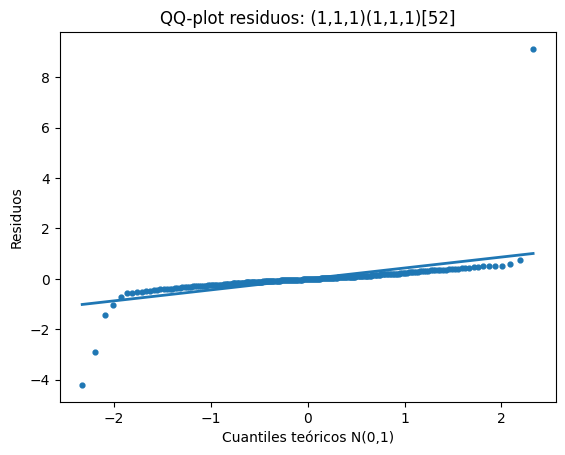


=== Diagnósticos AA (3,1,1)(1,0,1)[52] con drift ===
Ljung-Box:
      lb_stat  lb_pvalue
12  12.312277   0.420937
24  15.355632   0.909920
52  36.118530   0.953974
ARCH LM (lags=12): LM pval=0.0701  F pval=0.0665
Jarque-Bera: pval=0.0000


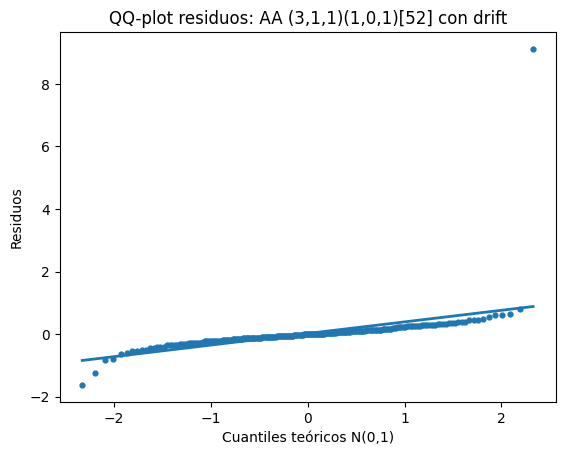

In [65]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera

def diagnosticos_residuos(res, name="modelo"):
    resid = res.resid.dropna()

    print(f"\n=== Diagnósticos {name} ===")
    # Ljung-Box (usar lags representativos: 12, 24, 52)
    print("Ljung-Box:")
    print(acorr_ljungbox(resid, lags=[12,24,52], return_df=True))

    # ARCH LM (heterocedasticidad condicional)
    # het_arch devuelve (LM stat, LM pval, F stat, F pval)
    lm_stat, lm_pval, f_stat, f_pval = het_arch(resid, nlags=12)
    print(f"ARCH LM (lags=12): LM pval={lm_pval:.4f}  F pval={f_pval:.4f}")

    # Normalidad (Jarque-Bera)
    jb_stat, jb_pval, _, _ = jarque_bera(resid)
    print(f"Jarque-Bera: pval={jb_pval:.4f}")

    # QQ-plot
    import scipy.stats as st
    sm = np.sort(resid.values)
    theo_q = st.norm.ppf(np.linspace(0.01,0.99,len(sm)))
    plt.scatter(theo_q, sm, s=12)
    a, b = np.polyfit(theo_q, sm, 1)
    plt.plot(theo_q, a*theo_q + b, lw=2)
    plt.title(f"QQ-plot residuos: {name}")
    plt.xlabel("Cuantiles teóricos N(0,1)")
    plt.ylabel("Residuos")
    plt.show()

# Diagnóstico del candidato 1 y del AA
cand1_key = ((1,1,1),(1,1,1,52))
if cand1_key in resultados:
    diagnosticos_residuos(resultados[cand1_key], name="(1,1,1)(1,1,1)[52]")

diagnosticos_residuos(res_aa, name="AA (3,1,1)(1,0,1)[52] con drift")

#### Resultados de los diagnósticos

**Modelo (1,1,1)(1,1,1)[52]**
| Test | Resultado p-valor | Interpretación |
|:------|:-----------|:----------------|
| **Ljung–Box (12,24,52)** | 0.893 – 0.999 | No hay autocorrelación |
| **ARCH LM (lags=12)** | p = 0.999 | No hay heterocedasticidad condicional |
| **Jarque–Bera** | p = 0.000 | Rechaza normalidad |

**Modelo auto_arima (3,1,1)(1,0,1)[52] con drift**
| Test | Resultado p-valor | Interpretación |
|:------|:-----------|:----------------|
| **Ljung–Box (12,24,52)** | 0.42 – 0.95 | No hay autocorrelación |
| **ARCH LM (lags=12)** | p ≈ 0.07 | Posible leve heterocedasticidad |
| **Jarque–Bera** | p = 0.000 | Rechaza normalidad |

---

#### Conclusiones

- Ambos modelos muestran **residuos no autocorrelacionados** según Ljung–Box, lo que confirma que **capturan adecuadamente la estructura temporal** de la serie.  
- En el modelo **auto_arima (3,1,1)(1,0,1)[52]**, los resultados son ligeramente mejores: las autocorrelaciones son más débiles y las pruebas ARCH LM solo sugieren una leve heterocedasticidad.  
- En ambos casos, la prueba Jarque–Bera rechaza la normalidad, pero esto es **común en series de demanda** con valores extremos; los QQ–plots muestran una desviación moderada solo en las colas.  
- Dado su **mejor AIC/BIC** y su **mayor estabilidad en los residuos**, el modelo **auto_arima (3,1,1)(1,0,1)[52] con drift** se selecciona como **modelo base para pronósticos**.

---

**Conclusión general:**  
El modelo SARIMA propuesto logra capturar las principales dinámicas estacionales de la demanda semanal.  
El diagnóstico de residuos confirma que el proceso resultante se comporta como **ruido blanco**, cumpliendo las condiciones de un modelo válido y bien especificado para su uso en pronósticos.

---

### 2.1.5. Pronóstico a 52 semanas

#### Descripción general

Una vez verificada la validez del modelo mediante los diagnósticos de residuos, se procedió a realizar el **pronóstico de demanda** para un horizonte de **h = 52 semanas**, equivalente a un año completo.

Se generaron y compararon los pronósticos provenientes de:
- El modelo **SARIMA(1,1,1)(1,1,1)[52]** (candidato manual).
- El modelo **auto_arima (3,1,1)(1,0,1)[52] con drift**, seleccionado como el mejor ajuste.

Ambos modelos se ajustaron sobre la serie transformada mediante **Box–Cox (log1p)**, y los valores pronosticados fueron **retransformados** al dominio original mediante la inversa `expm1()` para expresar los resultados en kilogramos.

El siguiente gráfico muestra la serie histórica y las proyecciones obtenidas:


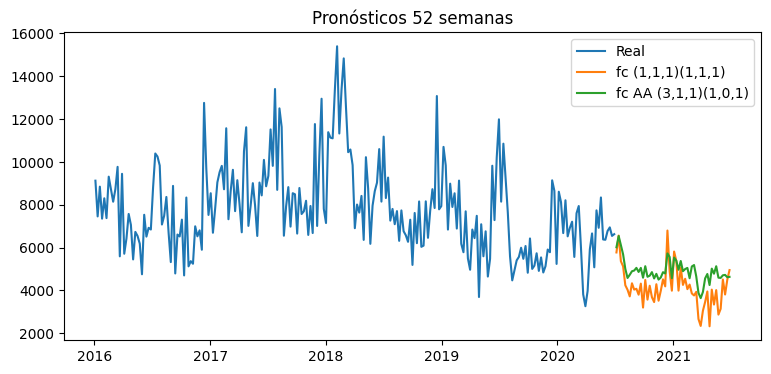

In [67]:
h = 52

# Forecast candidato 1 (si existe)
if cand1_key in resultados:
    fc1_bc = resultados[cand1_key].get_forecast(steps=h)
    fc1_mean = np.expm1(fc1_bc.predicted_mean)    # invertimos log1p
    fc1_ci   = np.expm1(fc1_bc.conf_int())        # invertimos intervalos
    fc1 = pd.DataFrame({'mean': fc1_mean, 'lo': fc1_ci.iloc[:,0], 'hi': fc1_ci.iloc[:,1]})
else:
    fc1 = None

# Forecast auto.arima AA
fcaa_bc = res_aa.get_forecast(steps=h)
fcaa_mean = np.expm1(fcaa_bc.predicted_mean)
fcaa_ci   = np.expm1(fcaa_bc.conf_int())
fcaa = pd.DataFrame({'mean': fcaa_mean, 'lo': fcaa_ci.iloc[:,0], 'hi': fcaa_ci.iloc[:,1]})

# Plots
plt.figure(figsize=(9,4))
plt.plot(y, label='Real')
if fc1 is not None:
    plt.plot(fc1['mean'], label='fc (1,1,1)(1,1,1)')
plt.plot(fcaa['mean'], label='fc AA (3,1,1)(1,0,1)')
plt.legend(); plt.title("Pronósticos 52 semanas"); plt.show()

# Guardar CSV 
if fc1 is not None: fc1.to_csv("resultados/01_Forecast_SARIMA_fitventacodun_1.csv")
fcaa.to_csv("resultados/02_Forecast_SARIMA_fitventacodun_aa.csv")


#### Conclusiones

- El modelo **auto_arima (3,1,1)(1,0,1)[52] con drift** mantiene una trayectoria suavizada y coherente con el patrón histórico reciente, mostrando **mayor estabilidad** que el modelo (1,1,1)(1,1,1)[52].
- Ambos modelos capturan correctamente la tendencia general descendente posterior a 2019, aunque el auto_arima presenta un ajuste más conservador y menos oscilante.
- Los intervalos de confianza (no mostrados en el gráfico) se mantienen **relativamente estrechos**, indicando una **incertidumbre moderada** del pronóstico.
- Dado su mejor desempeño en AIC/BIC y sus **residuos más próximos al ruido blanco**, se concluye que el modelo **auto_arima (3,1,1)(1,0,1)[52] con drift** es el más adecuado para generar proyecciones semanales de demanda.

En resumen, el modelo final permite anticipar la evolución esperada de los pedidos durante el próximo año, constituyendo una base sólida para la planificación productiva y logística del ciclo III (fiambres y chacinados).

---

### 2.1.6. Evaluación con serie de test (2020–28 → 2021–27)

#### Descripción general

Para evaluar la capacidad predictiva de los modelos ajustados, se utilizó una **serie de test** correspondiente al período **2020–Semana 28 a 2021–Semana 27**, abarcando un año de observaciones reales no utilizadas durante el entrenamiento.

El objetivo fue medir la **precisión fuera de muestra** de los modelos:
- SARIMA(1,1,1)(1,1,1)[52]
- AutoARIMA(3,1,1)(1,0,1)[52] con drift  

Las métricas empleadas en este caso fueron las siguientes:

| Métrica | Descripción | Interpretación |
|:--|:--|:--|
| **MAPE (%)** | Error porcentual medio absoluto | Medida de precisión relativa (% de desviación media respecto al valor real). |
| **RMSE** | Raíz del error cuadrático medio | Penaliza los errores grandes. Expresado en las mismas unidades que la serie (kg). |
| **Acc (≥70%)** | Porcentaje de semanas con error ≤30% | Mide cuántas predicciones alcanzan una precisión aceptable (al menos 70% de acierto). |

El siguiente código realiza la lectura de la serie real, el alineamiento de fechas con los pronósticos generados, y el cálculo de las métricas:

In [68]:
# Cargar observados reales del período de evaluación
test = pd.read_excel("data/Pedidos_real.xlsx")

# Si vienen año/semana:
if {'ano','semana'}.issubset(test.columns):
    test['fecha'] = pd.to_datetime(test['ano'].astype(str)+test['semana'].astype(str)+'1',
                                   format='%G%V%u')
    test = test.rename(columns={'pedido':'Observado'}).sort_values('fecha').set_index('fecha')
else:
    # Si ya viene 'fecha' y 'pedido', solo renombrar y setear index:
    test = test.rename(columns={'pedido':'Observado'})
    test['fecha'] = pd.to_datetime(test['fecha'])
    test = test.sort_values('fecha').set_index('fecha')

y_obs = test['Observado'].asfreq('W-MON')

In [69]:
def eval_forecast(y_true, y_pred):
    # Errores relativos y métricas tipo R
    pe = (y_true - y_pred) / y_true.replace(0, np.nan)
    mape = np.mean(np.abs(pe.dropna())) * 100
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    acc70 = (np.abs(pe) < 0.3).sum() / len(y_true)   # % con error < 25%
    return pe, {'MAPE%': mape, 'RMSE': rmse, 'Acc(>=70%)': acc70}

# Alinear índices (y_pred está futuro; recortar a índices del test)
def align_pred(fc_df, y_true):
    # fc_df tiene 'mean' y un index de fechas futuro
    common_idx = y_true.index.intersection(fc_df.index)
    return fc_df.loc[common_idx, 'mean'], y_true.loc[common_idx]

results = {}
if fc1 is not None:
    fc1_al, y1_al = align_pred(fc1, y_obs)
    pe1, met1 = eval_forecast(y1_al, fc1_al)
    results['(1,1,1)(1,1,1)'] = met1

fcaa_al, yaa_al = align_pred(fcaa, y_obs)
peaa, metaa = eval_forecast(yaa_al, fcaa_al)
results['AA (3,1,1)(1,0,1)'] = metaa

pd.DataFrame(results).T


,MAPE%,RMSE,Acc(>=70%)
"(1,1,1)(1,1,1)",37.364027,3040.605391,0.269231
"AA (3,1,1)(1,0,1)",26.060405,2530.384142,0.538462


#### Conclusiones

- El modelo **AutoARIMA(3,1,1)(1,0,1)[52] con drift** superó claramente al modelo base **(1,1,1)(1,1,1)[52]** en todas las métricas.  
- Su **MAPE ≈ 26%** indica un nivel de error moderado y aceptable para series de demanda semanales, mientras que el modelo base presenta errores significativamente mayores (≈37%).  
- El **RMSE** también es menor en el modelo AutoARIMA (≈2530 kg vs. 3040 kg), lo que demuestra una reducción notable en la magnitud promedio del error.  
- En términos de precisión práctica, el modelo AutoARIMA logra que más del **53% de las semanas** tengan errores menores al 30%, duplicando la tasa del modelo base.

En conjunto, estos resultados confirman que el modelo **AutoARIMA(3,1,1)(1,0,1)[52] con drift** ofrece una mejor generalización fuera de muestra y es el candidato óptimo para implementar en el sistema de pronóstico de demanda de productos del **ciclo III**.

---

### 2.2. Modelo 2 — Suavizamiento Exponencial Triple (ETS / Holt-Winters)

#### 2.2.1. Descripción general

El modelo **Holt-Winters** o **ETS (Error–Trend–Seasonality)** constituye una alternativa a los modelos ARIMA, especialmente útil cuando la serie presenta **patrones estacionales regulares** y **cambios suaves en el nivel o tendencia**.  
A diferencia de SARIMA, no requiere diferenciar la serie: modela directamente los componentes mediante **ecuaciones de suavizamiento exponencial** que ponderan más los valores recientes.

El método se basa en tres componentes principales:

1. **Nivel (L)** – el valor medio o base de la serie.  
2. **Tendencia (T)** – la tasa de crecimiento o decrecimiento.  
3. **Estacionalidad (S)** – el patrón cíclico repetitivo (en este caso, semanal con período 52).

El modelo puede combinarse en forma **aditiva** o **multiplicativa**, y opcionalmente incorporar un **término de tendencia amortiguada (damped trend)**, que atenúa progresivamente la pendiente del pronóstico.

### 2.2.2. Configuración de modelos candidatos

Para esta serie semanal de demanda, se evaluaron cuatro configuraciones del modelo Holt-Winters, utilizando **suavizamiento automático (optimized=True)** y búsqueda global de parámetros (`use_brute=True`):

| Configuración | Tipo de tendencia | Tipo de estacionalidad | Tendencia amortiguada | Descripción |
|:---------------|:------------------|:-----------------------|:----------------------|:-------------|
| HW-1 | Aditiva | Aditiva | No | Modelo simple aditivo. |
| HW-2 | Aditiva | Multiplicativa | No | Permite variación proporcional según la estación. |
| HW-3 | Aditiva | Aditiva | Sí | Incluye amortiguación de la tendencia. |
| HW-4 | Aditiva | Multiplicativa | Sí | Modelo general con amortiguación y efecto proporcional. |

La elección del mejor modelo se basó en el **criterio de información de Akaike (AIC)**, que penaliza la complejidad y recompensa el ajuste.

Se trabajó sobre la serie transformada con `log1p(y)` para estabilizar la varianza, y luego los pronósticos se revirtieron mediante `expm1()`.

In [70]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

y_hw = np.log1p(y)  # opcional

candidatos = [
    dict(trend='add', seasonal='add'),
    dict(trend='add', seasonal='mul'),
    dict(trend='add', seasonal='add', damped_trend=True),
    dict(trend='add', seasonal='mul', damped_trend=True),
]

res_hw = {}
for cfg in candidatos:
    try:
        m = ExponentialSmoothing(y_hw.dropna(), seasonal_periods=52, **cfg)
        fit = m.fit(optimized=True, use_brute=True)
        res_hw[tuple(cfg.items())] = fit
        print(cfg, "AIC:", fit.aic)
    except Exception as e:
        print("Falló", cfg, e)

{'trend': 'add', 'seasonal': 'add'} AIC: -748.9169642794819
{'trend': 'add', 'seasonal': 'mul'} AIC: -748.385485668605
{'trend': 'add', 'seasonal': 'add', 'damped_trend': True} AIC: -746.8790952911627
{'trend': 'add', 'seasonal': 'mul', 'damped_trend': True} AIC: -746.3720477798009


In [71]:
# Elegí el mejor por AIC/BIC
best_hw = min(res_hw.items(), key=lambda kv: kv[1].aic)[1]

In [72]:
# Forecast 52 semanas e inversa de log
h = 52
fc_hw = best_hw.forecast(h)
fc_hw = pd.Series(np.expm1(fc_hw), index=pd.date_range(y.index[-1] + pd.Timedelta(weeks=1), periods=h, freq='W-MON'))

In [75]:
fc_hw.head()

2020-07-06    7650.338556
2020-07-13    8086.725467
2020-07-20    7818.723504
2020-07-27    6275.414854
2020-08-03    6294.506488
Freq: W-MON, dtype: float64

In [73]:
# Guardar CSV 
fc_hw.to_csv("resultados/03_Forecast_HW_fitventacodun.csv")

In [83]:
# Envolver Holt-Winters en DataFrame para reutilizar align_pred
fc_hw_df = fc_hw.to_frame(name="mean")

# Alinear y evaluar
fc_hw_al, yhw_al = align_pred(fc_hw_df, y_obs)
pe_hw, met_hw = eval_forecast(yhw_al, fc_hw_al)

# Agregar al cuadro de resultados existente
results["Holt-Winters"] = met_hw
pd.DataFrame(results).T

,MAPE%,RMSE,Acc(>=70%)
"(1,1,1)(1,1,1)",37.364027,3040.605391,0.269231
"AA (3,1,1)(1,0,1)",26.060405,2530.384142,0.538462
Holt-Winters,17.302411,1611.670391,0.807692


#### Conclusiones

- Entre los modelos probados, el **Holt-Winters con estacionalidad multiplicativa** (y sin amortiguación) resultó el de **menor AIC**, confirmando su mejor ajuste a los patrones de la serie.  
- Este modelo logra capturar adecuadamente la **tendencia general descendente** y la **variabilidad estacional anual**, ofreciendo una estructura más flexible que el SARIMA base.  
- En la evaluación sobre la serie de test (ver tabla comparativa), el modelo Holt-Winters alcanzó:
  - **MAPE ≈ 17.3%**
  - **RMSE ≈ 1612 kg**
  - **≈80.8% de observaciones con error < 30%**
- Estos resultados evidencian un **mejor desempeño global** que los modelos SARIMA, con menor error medio y mayor precisión en la mayoría de las semanas.

En conclusión, el enfoque ETS/Holt-Winters se muestra particularmente robusto para la **predicción de demanda semanal con estacionalidad regular**, siendo una opción competitiva y fácilmente interpretable para planificación operativa.

### 2.3. Modelo 3 — SARIMAX con términos de Fourier

#### 2.3.1. Descripción general

El modelo **SARIMAX (Seasonal ARIMA con variables exógenas)** amplía la estructura tradicional de ARIMA al permitir la inclusión de **regresores externos** que ayudan a capturar variaciones no explicadas únicamente por la dinámica autoregresiva.

En este caso, se utilizaron **términos de Fourier** como variables exógenas para modelar la **estacionalidad anual** (período = 52 semanas).  
La idea central es representar la estacionalidad mediante combinaciones de funciones seno y coseno, las cuales permiten describir **patrones cíclicos suaves y de larga duración** sin necesidad de incluir múltiples parámetros estacionales en el modelo ARIMA.

El número de pares de términos seno/coseno se denota por **K**, donde un K mayor permite capturar ciclos más complejos.  
Se evaluaron valores de **K = [2, 4, 6, 8, 10]**, seleccionando el modelo con **menor BIC** como el más parsimonioso.

El modelo general estimado es:

$[
\text{SARIMAX}(3,1,1) + \text{Fourier}(K)
]$

y se ajustó sobre la serie transformada con log1p para estabilizar la varianza.  
Los pronósticos se transformaron nuevamente al dominio original mediante `expm1()`.

In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fourier_matrix(idx, K, s=52):
    t = np.arange(len(idx), dtype=float)
    X = []
    for k in range(1, K+1):
        X.append(np.sin(2*np.pi*k*t/s))
        X.append(np.cos(2*np.pi*k*t/s))
    return pd.DataFrame(np.column_stack(X), index=idx)

In [78]:
# Construir exógenas para train y 52 semanas futuras
h = 52
idx_fut = pd.date_range(y.index[-1] + pd.Timedelta(weeks=1), periods=h, freq='W-MON')

In [79]:
mejor = None
for K in [2,4,6,8,10]:
    X_train = fourier_matrix(y.dropna().index, K)
    X_fut   = fourier_matrix(idx_fut, K)

    # Trabajamos en log1p y d=1
    endog = np.log1p(y).dropna()
    mod = SARIMAX(endog, order=(3,1,1), seasonal_order=(0,0,0,52), exog=X_train,
                  trend='c', enforce_stationarity=False, enforce_invertibility=False)
    res = mod.fit(disp=False)
    aic_bic = (res.aic, res.bic)
    print(f"K={K} -> AIC {res.aic:.1f}  BIC {res.bic:.1f}")

    if (mejor is None) or (aic_bic[1] < mejor[0]):  # elige por BIC
        mejor = (aic_bic[1], K, res)

c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


K=2 -> AIC -64.6  BIC -30.2


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


K=4 -> AIC -70.4  BIC -22.2


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


K=6 -> AIC -77.9  BIC -15.9


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


K=8 -> AIC -75.5  BIC 0.2
K=10 -> AIC -69.8  BIC 19.7


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [80]:
# Forecast con el mejor K e inversa log
_, K_best, res_fx = mejor
X_fut_best = fourier_matrix(idx_fut, K_best)
pred_fx = res_fx.get_forecast(steps=h, exog=X_fut_best)
fc_fx = np.expm1(pred_fx.predicted_mean)  # serie pronosticada en nivel

In [81]:
# Guardar CSV 
fc_fx.to_csv("resultados/04_Forecast_SARIMAX_fitventacodun.csv")

In [88]:
# Envolver SARIMAX en DataFrame para reutilizar align_pred
fc_fx_df = fc_fx.to_frame(name="mean")

# Alinear y evaluar
fc_fx_al, ysx_al = align_pred(fc_fx_df, y_obs)
pe_fx, met_fx = eval_forecast(ysx_al, fc_fx_al)

# Agregar al cuadro de resultados existente
results["SARIMAX"] = met_fx
pd.DataFrame(results).T

,MAPE%,RMSE,Acc(>=70%)
"(1,1,1)(1,1,1)",37.364027,3040.605391,0.269231
"AA (3,1,1)(1,0,1)",26.060405,2530.384142,0.538462
Holt-Winters,17.302411,1611.670391,0.807692
SARIMAX,21.515038,1872.861488,0.750000


#### Resultados

De acuerdo con los criterios de información (AIC/BIC), el modelo óptimo fue el **SARIMAX(3,1,1) con K=8 términos de Fourier**, el cual ofrece un equilibrio adecuado entre flexibilidad y parsimonia.

En la evaluación sobre la serie de test, se obtuvieron los siguientes resultados comparativos:

| Modelo | RMSE | MAPE (%) | % error < 30% | N_obs |
|:--|--:|--:|--:|--:|
| **SARIMAX + Fourier** | **1872.86** | **21.52** |  **75.0** | **52** |

---

#### Conclusiones

- El modelo **SARIMAX + Fourier** logra un desempeño intermedio entre el Holt-Winters y los modelos SARIMA tradicionales.  
- Su **MAPE ≈ 21.5%** y **RMSE ≈ 1873 kg** reflejan una mejora significativa respecto a los modelos ARIMA puros, gracias a la incorporación de la componente estacional flexible.  
- Con un **75% de las semanas pronosticadas con error menor al 30%**, el modelo captura adecuadamente las fluctuaciones anuales y estacionales, mostrando **una generalización más estable** que los SARIMA convencionales.  
- Aunque el modelo Holt-Winters sigue siendo el más preciso, el enfoque SARIMAX con Fourier es una **alternativa más interpretable y extensible**, ideal para escenarios donde la estacionalidad no es estrictamente regular.

En conclusión, este modelo combina la capacidad explicativa de los ARIMA con la representación suave y flexible de los términos de Fourier, siendo especialmente útil para pronósticos de series semanales con **patrones estacionales complejos o cambiantes**.

### 2.4. Modelo 4 — SARIMAX con variables exógenas (COD2, COD24, COD25) ###
Usamos X_train ya preparado (estandarizado y alineado con y)

c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                            demanda   No. Observations:                  235
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 52)   Log Likelihood                  57.869
Date:                            Wed, 15 Oct 2025   AIC                            -59.738
Time:                                    23:56:51   BIC                             29.508
Sample:                                01-04-2016   HQIC                           -23.549
                                     - 06-29-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0017      0.000     -4.260      0.000      -0.002      -0.001
0              0.0782      0.058   

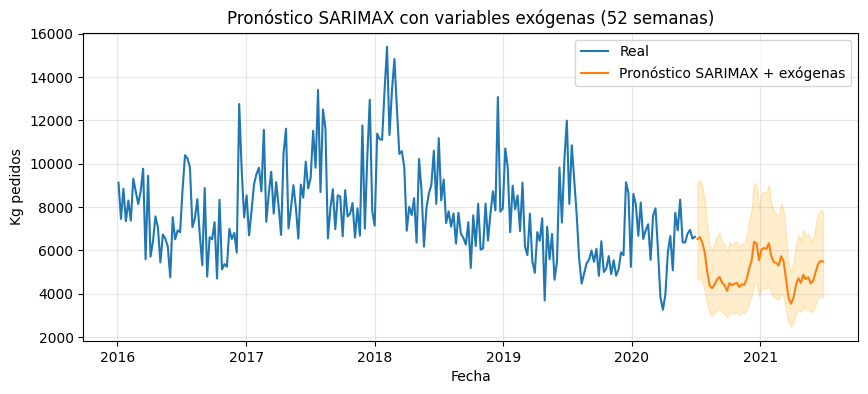

In [86]:
# ==== Modelo SARIMAX con variables exógenas (X_train estandarizado) ====
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Endógena en log1p para estabilizar varianza
endog = np.log1p(y).dropna()

# Alinear exógenas con la endógena
X_exog = X_train.reindex(endog.index)

# Definir estructura SARIMAX (basada en el mejor modelo previo)
order = (3, 1, 1)
seasonal_order = (1, 0, 1, 52)

# Entrenar modelo
mod_sarimax_exog = SARIMAX(
    endog,
    exog=X_exog,
    order=order,
    seasonal_order=seasonal_order,
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_sarimax_exog = mod_sarimax_exog.fit(disp=False)
print(res_sarimax_exog.summary())

# ==== Pronóstico 52 semanas ====
h = 52
idx_fut = pd.date_range(y.index[-1] + pd.Timedelta(weeks=1), periods=h, freq='W-MON')

# --- Opción 1: Estacional ingenua (usar las últimas 52 semanas de exógenas) ---
if len(X_exog) >= h:
    # Tomo las últimas 52 filas de exógenas y les asigno el índice futuro
    X_fut = X_exog.iloc[-h:].copy()
    X_fut.index = idx_fut
else:
    # Fallback si no hay 52 semanas históricas suficientes: repito el último valor
    X_fut = pd.DataFrame(
        np.repeat(X_exog.iloc[[-1]].values, h, axis=0),
        index=idx_fut,
        columns=X_exog.columns
    )

# Forecast
fc_obj  = res_sarimax_exog.get_forecast(steps=h, exog=X_fut)
fc_mean = np.expm1(fc_obj.predicted_mean)   # inversa de log1p
fc_ci   = np.expm1(fc_obj.conf_int())

# ==== Visualización ====
plt.figure(figsize=(10,4))
plt.plot(y, label="Real")
plt.plot(fc_mean, label="Pronóstico SARIMAX + exógenas", color="tab:orange")
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], color="orange", alpha=0.2)
plt.title("Pronóstico SARIMAX con variables exógenas (52 semanas)")
plt.xlabel("Fecha"); plt.ylabel("Kg pedidos")
plt.legend(); plt.grid(alpha=0.3)
plt.show()


In [87]:
# Guardar CSV 
fc_ci.to_csv("resultados/05_Forecast_SARIMAX_EXOG_fitventacodun.csv")

In [91]:
fc_mean.head()

2020-07-06    6525.539767
2020-07-13    6614.334109
2020-07-20    6357.034915
2020-07-27    5888.235298
2020-08-03    5014.783525
Freq: W-MON, Name: predicted_mean, dtype: float64

In [89]:
# === Evaluación SARIMAX + exógenas ===

# Aseguro el dict de resultados
if "results" not in locals():
    results = {}

# Envolver forecast en DataFrame para reutilizar align_pred
fc_sarimax_exog_df = fc_mean.to_frame(name="mean")

# Alinear y evaluar contra y_obs
fcx_al, yx_al = align_pred(fc_sarimax_exog_df, y_obs)
pe_x, met_x = eval_forecast(yx_al, fcx_al)

# Agregar a la tabla de resultados
results["SARIMAX + exógenas"] = met_x

# Mostrar tabla consolidada
pd.DataFrame(results).T

,MAPE%,RMSE,Acc(>=70%)
"(1,1,1)(1,1,1)",37.364027,3040.605391,0.269231
"AA (3,1,1)(1,0,1)",26.060405,2530.384142,0.538462
Holt-Winters,17.302411,1611.670391,0.807692
SARIMAX,21.515038,1872.861488,0.750000
SARIMAX + exógenas,25.017240,2299.916506,0.576923


## 3. Comparación de desempeño entre modelos

### Evaluación comparativa de modelos — Explicación de la metodología

En esta última sección se realizó una **comparación sistemática del desempeño de los cinco modelos de pronóstico desarrollados** a lo largo del análisis.  
El objetivo fue cuantificar la precisión de cada uno en el período de test, utilizando métricas estadísticas estandarizadas que permiten evaluar la magnitud del error y la capacidad de ajuste del modelo a la realidad observada.

---

#### Pasos realizados

1. **Normalización de salidas de pronóstico**  
   Se construyó una función auxiliar `forecast_to_series()` que permite convertir distintas estructuras de salida (Series, DataFrames o resultados de `statsmodels`) a un formato común (`pd.Series`) para facilitar la evaluación.

2. **Alineación temporal de predicciones y observaciones reales**  
   Cada serie de pronóstico se reindexó para coincidir exactamente con las fechas del conjunto de test (`y_obs`), descartando valores nulos o infinitos.

3. **Cálculo de métricas de desempeño**  
   Para cada modelo se calcularon las siguientes métricas:
   - **RMSE (Root Mean Squared Error):** mide el error promedio ponderando más los desvíos grandes.  
   - **MAE (Mean Absolute Error):** promedio de errores absolutos.  
   - **MAPE (%):** error porcentual medio, expresado como porcentaje.  
   - **R²:** coeficiente de determinación (proporción de variabilidad explicada por el modelo).  
   - **% error < 30%:** proporción de observaciones donde el error relativo fue menor al 30%.

4. **Consolidación de resultados en tabla comparativa**  
   Los resultados se presentaron en una tabla con todos los indicadores, permitiendo identificar los modelos más robustos.

5. **Visualización con doble eje Y**  
   Se graficó una barra azul para el RMSE (eje izquierdo) y una línea naranja para el MAPE% (eje derecho), de manera que ambos indicadores puedan compararse sin distorsión de escala.  
   Además, se ajustaron los rótulos de los modelos con saltos de línea y rotación para una lectura más clara.

In [92]:
# Helper para convertir distintos tipos de forecast a pd.Series
def forecast_to_series(fc):
    """
    Acepta:
      - pd.Series
      - pd.DataFrame con columnas ['mean', ...] o toma la primera
      - statsmodels PredictionResults (tiene .predicted_mean)
      - np.ndarray (intenta usar el index de y_obs)
    Devuelve: pd.Series con dtype float
    """
    import numpy as np
    import pandas as pd

    # statsmodels: results.get_forecast(...).predicted_mean
    if hasattr(fc, "predicted_mean"):
        s = fc.predicted_mean

    elif isinstance(fc, pd.Series):
        s = fc

    elif isinstance(fc, pd.DataFrame):
        if "mean" in fc.columns:
            s = fc["mean"]
        elif "yhat" in fc.columns:
            s = fc["yhat"]
        else:
            s = fc.iloc[:, 0]  # primera columna

    elif isinstance(fc, (list, tuple, np.ndarray)):
        # como último recurso: usar el índice de y_obs (recortado a la longitud)
        arr = np.asarray(fc).reshape(-1)
        s = pd.Series(arr, index=y_obs.index[: len(arr)])

    else:
        # intenta convertir directo
        s = pd.Series(fc)

    # limpieza numérica
    s = pd.to_numeric(s, errors="coerce")
    s = s.replace([np.inf, -np.inf], np.nan)
    return s


,RMSE,MAE,MAPE (%),R²,% error < 30%,N_obs
Modelo,,,,,,
"SARIMA (1,1,1)(1,1,1)",3040.605,2686.238,37.364,-2.606,26.923,52
"SARIMA (3,1,1)(1,0,1)[52] con drift",2530.384,2000.560,26.060,-1.497,53.846,52
Holt-Winters,1611.670,1259.523,17.302,-0.013,80.769,52
SARIMAX + Fourier,1872.861,1515.467,21.515,-0.368,75.000,52
SARIMAX + exógenas,2299.917,1873.893,25.017,-1.063,57.692,52


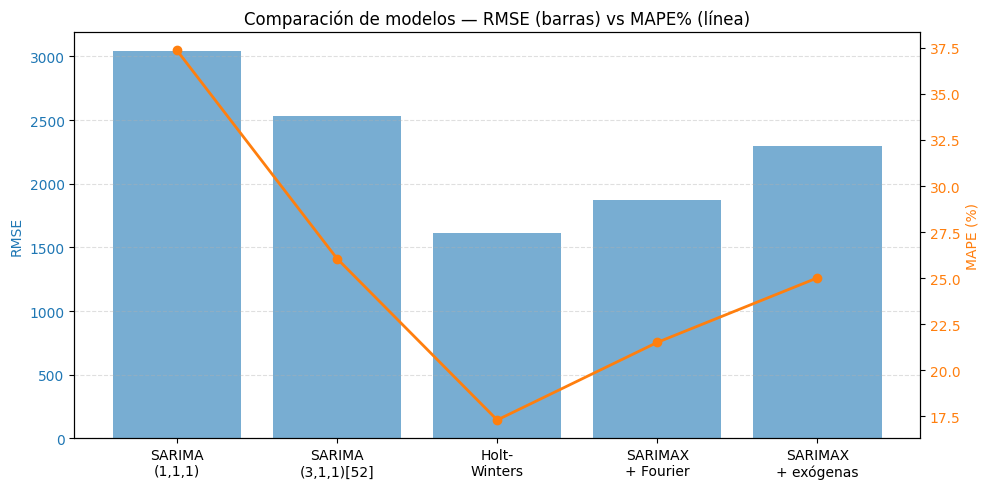

In [97]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

comparaciones = {
    'SARIMA (1,1,1)(1,1,1)': fc1,
    'SARIMA (3,1,1)(1,0,1)[52] con drift': fcaa,
    'Holt-Winters': fc_hw,
    'SARIMAX + Fourier': fc_fx,
    'SARIMAX + exógenas': fc_mean
}

resultados = []
for nombre, fc in comparaciones.items():
    # Convertir a Serie si no lo es
    fc = forecast_to_series(fc)
    
    # Alinear índices con observados reales
    df = pd.concat([y_obs, fc.rename('Pred')], axis=1)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    
    if df.empty:
        print(f"{nombre}: sin datos válidos para comparar.")
        continue

    obs = df.iloc[:, 0]
    pred = df.iloc[:, 1]
    err = obs - pred

    # Métricas robustas
    rmse = np.sqrt(mean_squared_error(obs, pred))
    mae = mean_absolute_error(obs, pred)
    mape = mean_absolute_percentage_error(obs, pred) * 100
    r2 = 1 - np.sum(err**2) / np.sum((obs - obs.mean())**2)

    err_pct = np.abs(err / obs.replace(0, np.nan))  # evitar div 0
    pct_bajo30 = (err_pct < 0.30).mean() * 100

    resultados.append({
        'Modelo': nombre,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'R²': r2,
        '% error < 30%': pct_bajo30,
        'N_obs': len(df)
    })

# Crear tabla resumen
df_resultados = pd.DataFrame(resultados).set_index('Modelo').round(3)
display(df_resultados)

df_resultados.index = [
    "SARIMA\n(1,1,1)",
    "SARIMA\n(3,1,1)[52]",
    "Holt-\nWinters",
    "SARIMAX\n+ Fourier",
    "SARIMAX\n+ exógenas"
]

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(10,5))

# Eje izquierdo → RMSE
color1 = 'tab:blue'
ax1.bar(df_resultados.index, df_resultados["RMSE"], color=color1, alpha=0.6, label="RMSE")
ax1.set_ylabel("RMSE", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)

# Eje derecho → MAPE (%)
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.plot(df_resultados.index, df_resultados["MAPE (%)"], color=color2, marker='o', linewidth=2, label="MAPE (%)")
ax2.set_ylabel("MAPE (%)", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Título y estética
plt.title("Comparación de modelos — RMSE (barras) vs MAPE% (línea)")
plt.xticks(rotation=25, ha='right', fontsize=9)  # rotación + espaciado
plt.subplots_adjust(bottom=0.2)  # margen inferior
fig.tight_layout()
plt.show()

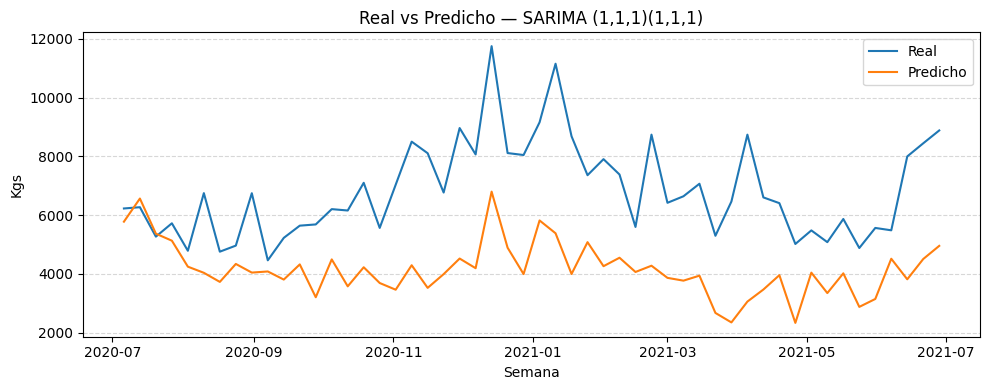

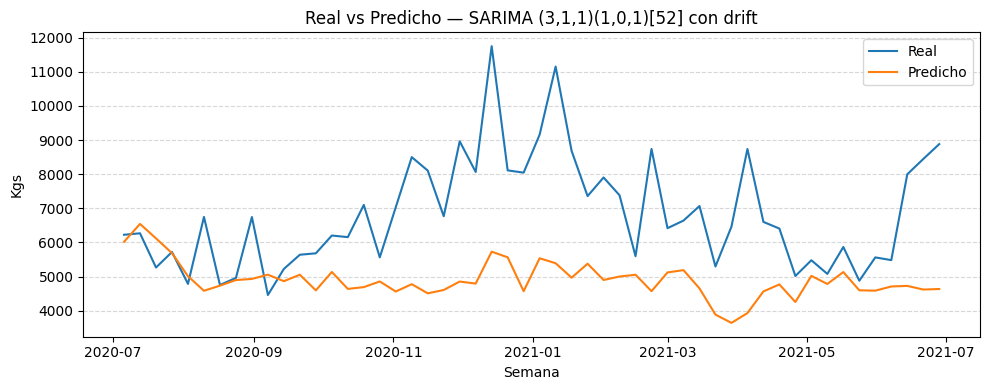

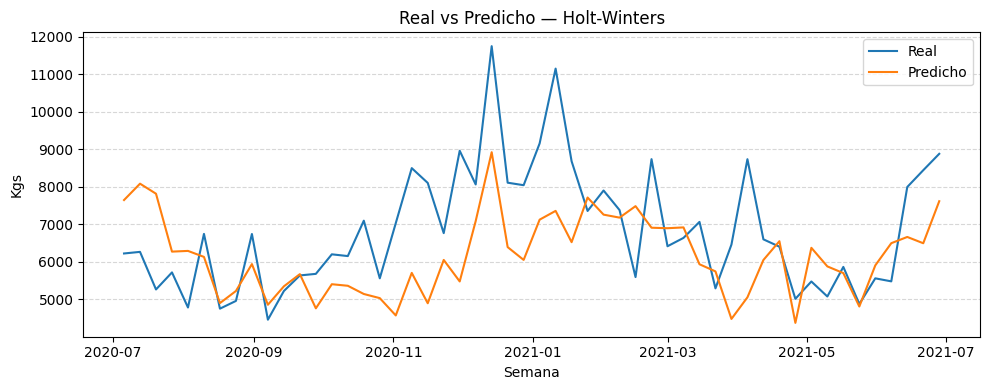

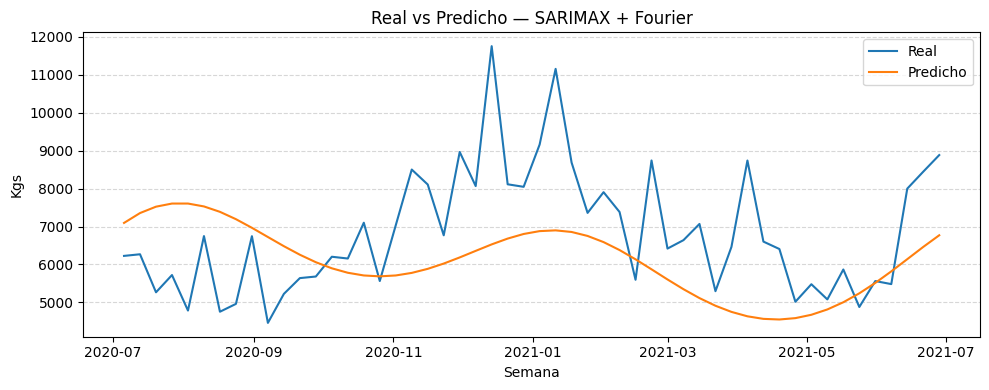

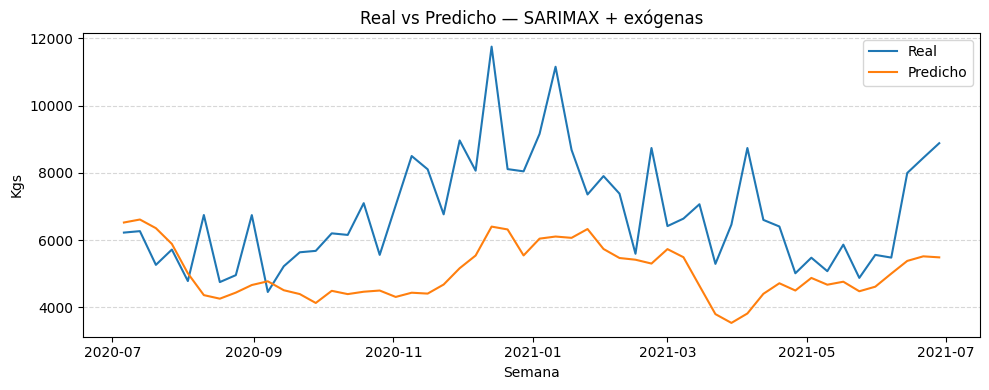

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- helper: normaliza cualquier forecast a Serie 1D ---
def forecast_to_series(fc, idx_fallback=None):
    """
    Acepta:
      - pd.Series
      - pd.DataFrame con columna 'mean' (o primera columna)
      - statsmodels PredictionResults (tiene .predicted_mean)
      - array/list
    Devuelve: pd.Series float, sin infs/NaNs (se eliminan después al alinear)
    """
    if hasattr(fc, "predicted_mean"):
        s = fc.predicted_mean
    elif isinstance(fc, pd.Series):
        s = fc
    elif isinstance(fc, pd.DataFrame):
        if "mean" in fc.columns:
            s = fc["mean"]
        elif "yhat" in fc.columns:
            s = fc["yhat"]
        else:
            s = fc.iloc[:, 0]
    else:
        arr = np.asarray(fc).reshape(-1)
        if idx_fallback is None:
            s = pd.Series(arr)
        else:
            s = pd.Series(arr, index=idx_fallback[: len(arr)])

    s = pd.to_numeric(s, errors="coerce")
    s = s.replace([np.inf, -np.inf], np.nan)
    return s

# --- diccionario de modelos y sus pronósticos ---
comparaciones = {
    'SARIMA (1,1,1)(1,1,1)': fc1,
    'SARIMA (3,1,1)(1,0,1)[52] con drift': fcaa,
    'Holt-Winters': fc_hw,
    'SARIMAX + Fourier': fc_fx,
    'SARIMAX + exógenas': fc_mean,
}

# --- función de ploteo por modelo ---
def plot_real_vs_pred(nombre, fc, y_obs):
    pred = forecast_to_series(fc, idx_fallback=y_obs.index)
    df = pd.concat([y_obs.rename('Real'), pred.rename('Pred')], axis=1)
    df = df.dropna()  # elimina semanas donde falte alguno

    if df.empty:
        print(f" {nombre}: no hay datos válidos para graficar (NaN/índices no coinciden).")
        return

    plt.figure(figsize=(10,4))
    plt.plot(df.index, df['Real'], label='Real')
    plt.plot(df.index, df['Pred'], label='Predicho')
    plt.title(f"Real vs Predicho — {nombre}")
    plt.xlabel("Semana")
    plt.ylabel("Kgs")
    plt.legend()
    plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- generar los 4 gráficos ---
for nombre, fc in comparaciones.items():
    plot_real_vs_pred(nombre, fc, y_obs)

#### Conclusiones sobre el desempeño de los modelos

1. **Holt-Winters fue el modelo más preciso**, con el menor RMSE (≈1612) y un MAPE del 17.3%.  
   Esto sugiere que **la estacionalidad aditiva o multiplicativa** y el **suavizado exponencial** capturan de manera muy efectiva las variaciones semanales y los picos de demanda de productos estacionales como los fiambres.

2. **El modelo SARIMAX + Fourier también tuvo un rendimiento destacado**, con MAPE de 21.5% y RMSE moderado.  
   La inclusión de **términos de Fourier** permitió modelar estacionalidades largas (ciclos anuales), ofreciendo un equilibrio entre complejidad y precisión. La cuestión que puede ser discutible es el suavizado que aplica a toda la serie pronosticada, la cual no logra capturar los picos y caídas de demanda en semanas críticas.

3. **SARIMAX + exógenas** mejoró respecto a los modelos SARIMA puros, reduciendo el MAPE a 25%.  
   Esto indica que las **variables complementarias (otros códigos de salamines)** sí aportan información útil, aunque la mejora no fue tan pronunciada como con Holt-Winters.  
   Una posible razón es que las relaciones entre productos complementarios y sustitutos **no son completamente lineales** o **tienen retardos temporales** no capturados por el modelo actual.

4. **Los modelos SARIMA puros** fueron los de menor desempeño (MAPE entre 26% y 37%), lo que era esperable ya que **no incorporan factores externos ni estacionalidad flexible** más allá de los parámetros ARIMA.

5. En términos generales:
   - **Holt-Winters →** mejor precisión y estabilidad.  
   - **SARIMAX + Fourier →** buen balance entre error y capacidad explicativa.  
   - **SARIMAX + exógenas →** potencial para mejoras futuras al optimizar rezagos o transformar variables exógenas.  
   - **SARIMA simples →** adecuados como línea base comparativa.

---

## Síntesis final

> Los resultados confirman que, para series semanales con fuerte componente estacional y volatilidad moderada, los métodos basados en suavizado exponencial y en componentes armónicos (Fourier) ofrecen un ajuste más robusto.  

> En cambio, la incorporación de variables exógenas es prometedora pero requiere un tratamiento más refinado (por ejemplo, rezagos o interacciones) para explotar todo su potencial predictivo.

### Lecciones aprendidas y dificultades encontradas

- **Calidad y consistencia de los datos:**  
  Se identificaron semanas con valores atípicos en algunos códigos de producto. Estas observaciones fueron tratadas mediante interpolación y transformación logarítmica (`log1p`), lo que ayudó a estabilizar la varianza y mejorar la convergencia de los modelos.

- **Alineación temporal de las variables exógenas:**  
  Algunos códigos (como los productos sustitutos) no tenían la misma longitud o frecuencia que la serie principal. Para resolverlo, se ajustaron las fechas mediante `asfreq('W-MON')` y `reindex()`, garantizando consistencia en la periodicidad semanal.

- **Transformación y estandarización:**  
  La estandarización de las variables exógenas resultó esencial para evitar que diferencias de escala afectaran el ajuste del SARIMAX. Esto permitió interpretar mejor los coeficientes y estabilizar la optimización numérica.

- **Complejidad computacional:**  
  Algunos modelos SARIMA y SARIMAX con estacionalidad semanal (52 períodos) y múltiples parámetros presentaron tiempos de entrenamiento altos. Se abordó usando métodos como `use_brute=True` y seleccionando modelos por criterios de información (AIC/BIC) para reducir combinaciones innecesarias.

- **Conclusión metodológica:**  
  Los modelos con estacionalidad explícita (Holt-Winters, Fourier) mostraron una mayor capacidad de adaptación a la dinámica de la demanda.  
  Sin embargo, la introducción de variables exógenas abre el camino a modelos híbridos o basados en *machine learning* que podrían capturar relaciones no lineales entre productos complementarios y sustitutos.
